In [1]:
import json, numpy as np, pandas as pd, time
from collections import defaultdict, OrderedDict
from copy import deepcopy
import datetime
from pandas import *
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
task_name = "新闻"  # 诚信数据 政府网站 新闻
check_start_date = '2019.1'  # eg: 2018.6 or 2018, if just year, it will be marked as January
check_end_date = ''  # default is Now Time

In [3]:
developer = ["陈子昂", "胡耀龙", "金伟", "郭正霆", "余依哲"]
developer_done_states = {'代码完成', '开发完成'}
developer_modify_states = {'研发修改完成'}
states = ["开发完成", "修改完成"]

In [4]:
if '.' in check_start_date and check_start_date.count('.') < 2:
    check_start_year, check_start_month = [int(date) for date in check_start_date.split('.')]
else:
    check_start_year = int(check_start_date)
    check_start_month = 1
check_start_timestamp = int(datetime.datetime(check_start_year, check_start_month, 1).timestamp())
try:
    if check_end_date:
        if '.' in check_end_date and check_end_date.count('.') < 2:
            check_end_year, check_end_month = [int(date) for date in check_end_date.split('.')]
        else:
            check_end_year = int(check_start_date)
            check_end_month = 1
        check_end_timestamp = int(datetime.datetime(check_end_year, check_end_month, 1).timestamp())
        check_end_date_flag = 1
    else:
        check_end_date_flag = 0
except:
    check_end_date_flag = 0
def get_data(name, version=1, flag=False):
    try:
        with open('%s.json' % name, 'r', encoding='utf-8') as json_file:
            return json.loads(json_file.read())[name]
    except FileNotFoundError:
        if flag:
            raise Exception('二次加载数据失败！')
        try:
            from mysql_database import get_version_data
            get_version_data(name, version)
            return get_data(name, version, True)
        except:
            raise Exception('没有对应的JSON文件，也没有加载数据的代码，请联系开发！')
def get_spider_tasks(data_list, key=None, dupefilter=()):
    spider_tasks = defaultdict(list)
    for data in data_list:
        if data[key or 'spiderName'] in dupefilter:
            continue
        spider_tasks[data[key or 'spiderName']].append(data)
    return spider_tasks
task_data = get_data(task_name)
spider_tasks = get_spider_tasks(task_data, key='by')
spider_tasks = {key:value for key, value in spider_tasks.items() if key in developer}
spider_tasks

{'郭正霆': [{'time': 1532668043,
   'id': 15346,
   'spiderName': '北极星电力网',
   'by': '郭正霆',
   'rwzt': '正在解析'},
  {'time': 1532678730,
   'id': 15418,
   'spiderName': '深圳商报',
   'by': '郭正霆',
   'rwzt': '正在修改'},
  {'time': 1532681572,
   'id': 15434,
   'spiderName': '第一商业网',
   'by': '郭正霆',
   'rwzt': '正在解析'},
  {'time': 1532912557,
   'id': 15449,
   'spiderName': '深圳商报',
   'by': '郭正霆',
   'rwzt': '疑难网站'},
  {'time': 1532915122,
   'id': 15452,
   'spiderName': '慧聪工程机械网',
   'by': '郭正霆',
   'rwzt': '正在修改'},
  {'time': 1532917100,
   'id': 15459,
   'spiderName': '第一商业网',
   'by': '郭正霆',
   'rwzt': '解析完成'},
  {'time': 1532918155,
   'id': 15464,
   'spiderName': '中金所',
   'by': '郭正霆',
   'rwzt': '正在解析'},
  {'time': 1532938089,
   'id': 15509,
   'spiderName': '中金所',
   'by': '郭正霆',
   'rwzt': '解析完成'},
  {'time': 1532938117,
   'id': 15510,
   'spiderName': '北极星电力网',
   'by': '郭正霆',
   'rwzt': '解析完成'},
  {'time': 1532942832,
   'id': 15533,
   'spiderName': '新浪地产',
   'by': '郭正霆',
   'rw

In [5]:
def get_time_format(timestamp):
    current_time = datetime.datetime.fromtimestamp(timestamp)
    year = current_time.year
    month = current_time.month
    day = current_time.day
    return f'{year}年{month}月', f'{year}年{month}月{day}日', current_time.hour
def get_date_template(check_start_year, check_start_month, end_year=None, end_month=None):
    if all((end_year, end_month)):
        year, month = end_year, end_month
    elif not check_end_date_flag:
        now = datetime.datetime.now()
        year, month = now.year, now.month
    else:
        year, month = check_end_year, check_end_month
    date_template = OrderedDict()
    time_format_1 = '%d年%d月'
    while check_start_year <= year:
        if check_start_month < 13:
            date_template[time_format_1 % (check_start_year, check_start_month)] = 0
            if check_start_year == year and check_start_month == month:
                break
            check_start_month += 1
        else:
            check_start_year += 1
            check_start_month = 1
            date_template[time_format_1 % (check_start_year, check_start_month)] = 0
    return date_template
date_template = get_date_template(check_start_year, check_start_month)

In [16]:
user_info = {}
for key, tasks in spider_tasks.items():
    done_count = modify_count = 0
    done_date_count = {}
    modify_date_count = {}
    done_user_habit_by_day_list = []
    modify_user_habit_by_hour_list = []
    done_date_count_by_day = defaultdict(dict)
    modify_date_count_by_day = defaultdict(dict)
    for task in tasks:
        date_key, date_key_by_day, hour = get_time_format(task['time'])
        if task['rwzt'] in developer_done_states:
            done_count += 1
            done_date_count[date_key] = done_date_count.setdefault(date_key, 0) + 1
            done_date_count_by_day[date_key][date_key_by_day] = done_date_count_by_day[date_key].setdefault(date_key_by_day, 0) + 1
            done_user_habit_by_day_list.append(hour)
        if task['rwzt'] in developer_modify_states:
            modify_count += 1
            modify_date_count[date_key] = modify_date_count.setdefault(date_key, 0) + 1
            modify_date_count_by_day[date_key][date_key_by_day] = modify_date_count_by_day[date_key].setdefault(date_key_by_day, 0) + 1
            modify_user_habit_by_hour_list.append(hour)
    done_date_count['count'] = done_count
    modify_date_count['count'] = modify_count
    user_info[key] = dict(done=done_date_count, 
                        modify=modify_date_count,
                        done_by_day=done_date_count_by_day,
                        modify_by_day=modify_date_count_by_day,
                        done_habit=done_user_habit_by_day_list,  # 这玩意可以画雷达图，表示用户的完成习惯
                        modify_habit=modify_user_habit_by_hour_list)
user_info_base = deepcopy(user_info)
user_info

{'郭正霆': {'done': {'2019年5月': 7,
   '2019年6月': 7,
   '2019年8月': 38,
   '2019年9月': 50,
   '2019年10月': 19,
   'count': 121},
  'modify': {'2018年8月': 168,
   '2018年9月': 209,
   '2018年10月': 114,
   '2018年11月': 57,
   '2019年2月': 36,
   '2019年8月': 1,
   '2019年9月': 27,
   '2019年10月': 9,
   'count': 621},
  'done_by_day': defaultdict(dict,
              {'2019年5月': {'2019年5月24日': 7},
               '2019年6月': {'2019年6月18日': 7},
               '2019年8月': {'2019年8月13日': 1,
                '2019年8月14日': 2,
                '2019年8月15日': 1,
                '2019年8月16日': 2,
                '2019年8月19日': 4,
                '2019年8月20日': 6,
                '2019年8月21日': 8,
                '2019年8月22日': 3,
                '2019年8月23日': 10,
                '2019年8月31日': 1},
               '2019年9月': {'2019年9月2日': 4,
                '2019年9月3日': 1,
                '2019年9月4日': 1,
                '2019年9月5日': 2,
                '2019年9月6日': 25,
                '2019年9月16日': 6,
                '2019年9月17日':

In [7]:
user_info_count = []  # [每月开发完成总量， 每月修改完成总量]
for i, name in enumerate(developer):
    user_info_count.append([user_info[name]['done']['count'], user_info[name]['modify']['count']])

for key in date_template:
    date_template[key] = [[0,0] for i in range(len(developer))]
for i, name in enumerate(developer):
    for month, value in user_info[name]['done'].items():
        if month in date_template:
            date_template[month][i][0] = value
    for month, value in user_info[name]['modify'].items():
        if month in date_template:
            date_template[month][i][1] = value
# print(user_info_count)
# date_template

In [8]:
months = date_template.keys()
months_count_info = OrderedDict()
for month in months:
    user_info_list = defaultdict(list)
    for user, tasks in user_info.items():
        done_by_day = tasks['done_by_day']
        modify_by_day = tasks['modify_by_day']
        user_info_list[user].append(list(done_by_day[month].values()) if month in done_by_day else [])
        user_info_list[user].append(list(modify_by_day[month].values()) if month in modify_by_day else [])
    months_count_info[month] = user_info_list
months_count_info  # 每月份，各开发 日开发天数及日开发量 日修改天数及日修改量

OrderedDict([('2019年1月',
              defaultdict(list,
                          {'郭正霆': [[], []],
                           '余依哲': [[], []],
                           '陈子昂': [[], []],
                           '金伟': [[], []],
                           '胡耀龙': [[], []]})),
             ('2019年2月',
              defaultdict(list,
                          {'郭正霆': [[], [1, 6, 1, 4, 6, 16, 2]],
                           '余依哲': [[], [1, 4]],
                           '陈子昂': [[], []],
                           '金伟': [[], []],
                           '胡耀龙': [[], []]})),
             ('2019年3月',
              defaultdict(list,
                          {'郭正霆': [[], []],
                           '余依哲': [[], []],
                           '陈子昂': [[], []],
                           '金伟': [[], []],
                           '胡耀龙': [[], []]})),
             ('2019年4月',
              defaultdict(list,
                          {'郭正霆': [[], []],
                           '余依哲': [[],

In [9]:
labels = ['']
for i in 'anc':
    labels.extend([i, ''])
all_labels = []
all_user_infos = []
bar_done_list = []
bar_modify_list = []
for month, user_infos in months_count_info.items():
    labels = [month]
    all_count = ['总量']
    all_days = ['总天数']
    count_max = ['max']
    count_80 = ['80%']
    count_mid = ['mid']
    count_30 = ['30%']
    count_min = ['min']
    count_average = ['平均']
    done = modify = 0
    for name in developer:
        labels.extend([name, ''])
        user_info = user_infos[name]
        done_task = user_info[0]
        modify_task = user_info[1]
        done_task.sort()
        modify_task.sort()
        sum_value1 = int(sum(done_task))
        done += sum_value1
        sum_value2 = int(sum(modify_task))
        modify += sum_value2
        all_count.extend([sum_value1, sum_value2])
        all_days.extend([len(done_task), len(modify_task)])
        count_max.extend([max(done_task) if done_task else 0, max(modify_task) if modify_task else 0])
        count_80.extend([done_task[int(len(done_task)*0.8)] if done_task else 0,
                        modify_task[int(len(modify_task)*0.8)] if modify_task else 0])
        count_mid.extend([done_task[int(len(done_task)*0.5)] if done_task else 0,
                         modify_task[int(len(modify_task)*0.5)] if modify_task else 0])
        count_30.extend([done_task[int(len(done_task)*0.3)] if done_task else 0,
                        modify_task[int(len(modify_task)*0.3)] if modify_task else 0])
        count_min.extend([min(done_task) if done_task else 0, min(modify_task) if modify_task else 0])
        count_average.extend([round(sum_value1/len(done_task), 1) if sum_value1 else 0, 
                              round(sum_value2/len(modify_task), 1) if sum_value2 else 0])
    all_labels.append(labels)
    all_user_infos.append([all_count, all_days, count_max, count_80, count_mid, count_30, count_min, count_average])
    bar_done_list.append(done)
    bar_modify_list.append(modify)
# all_user_infos

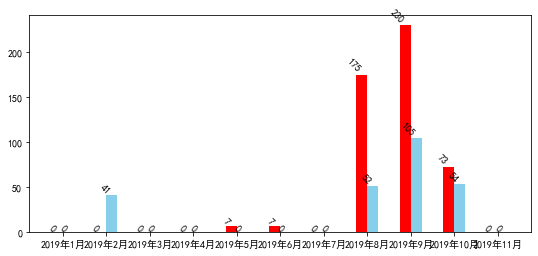

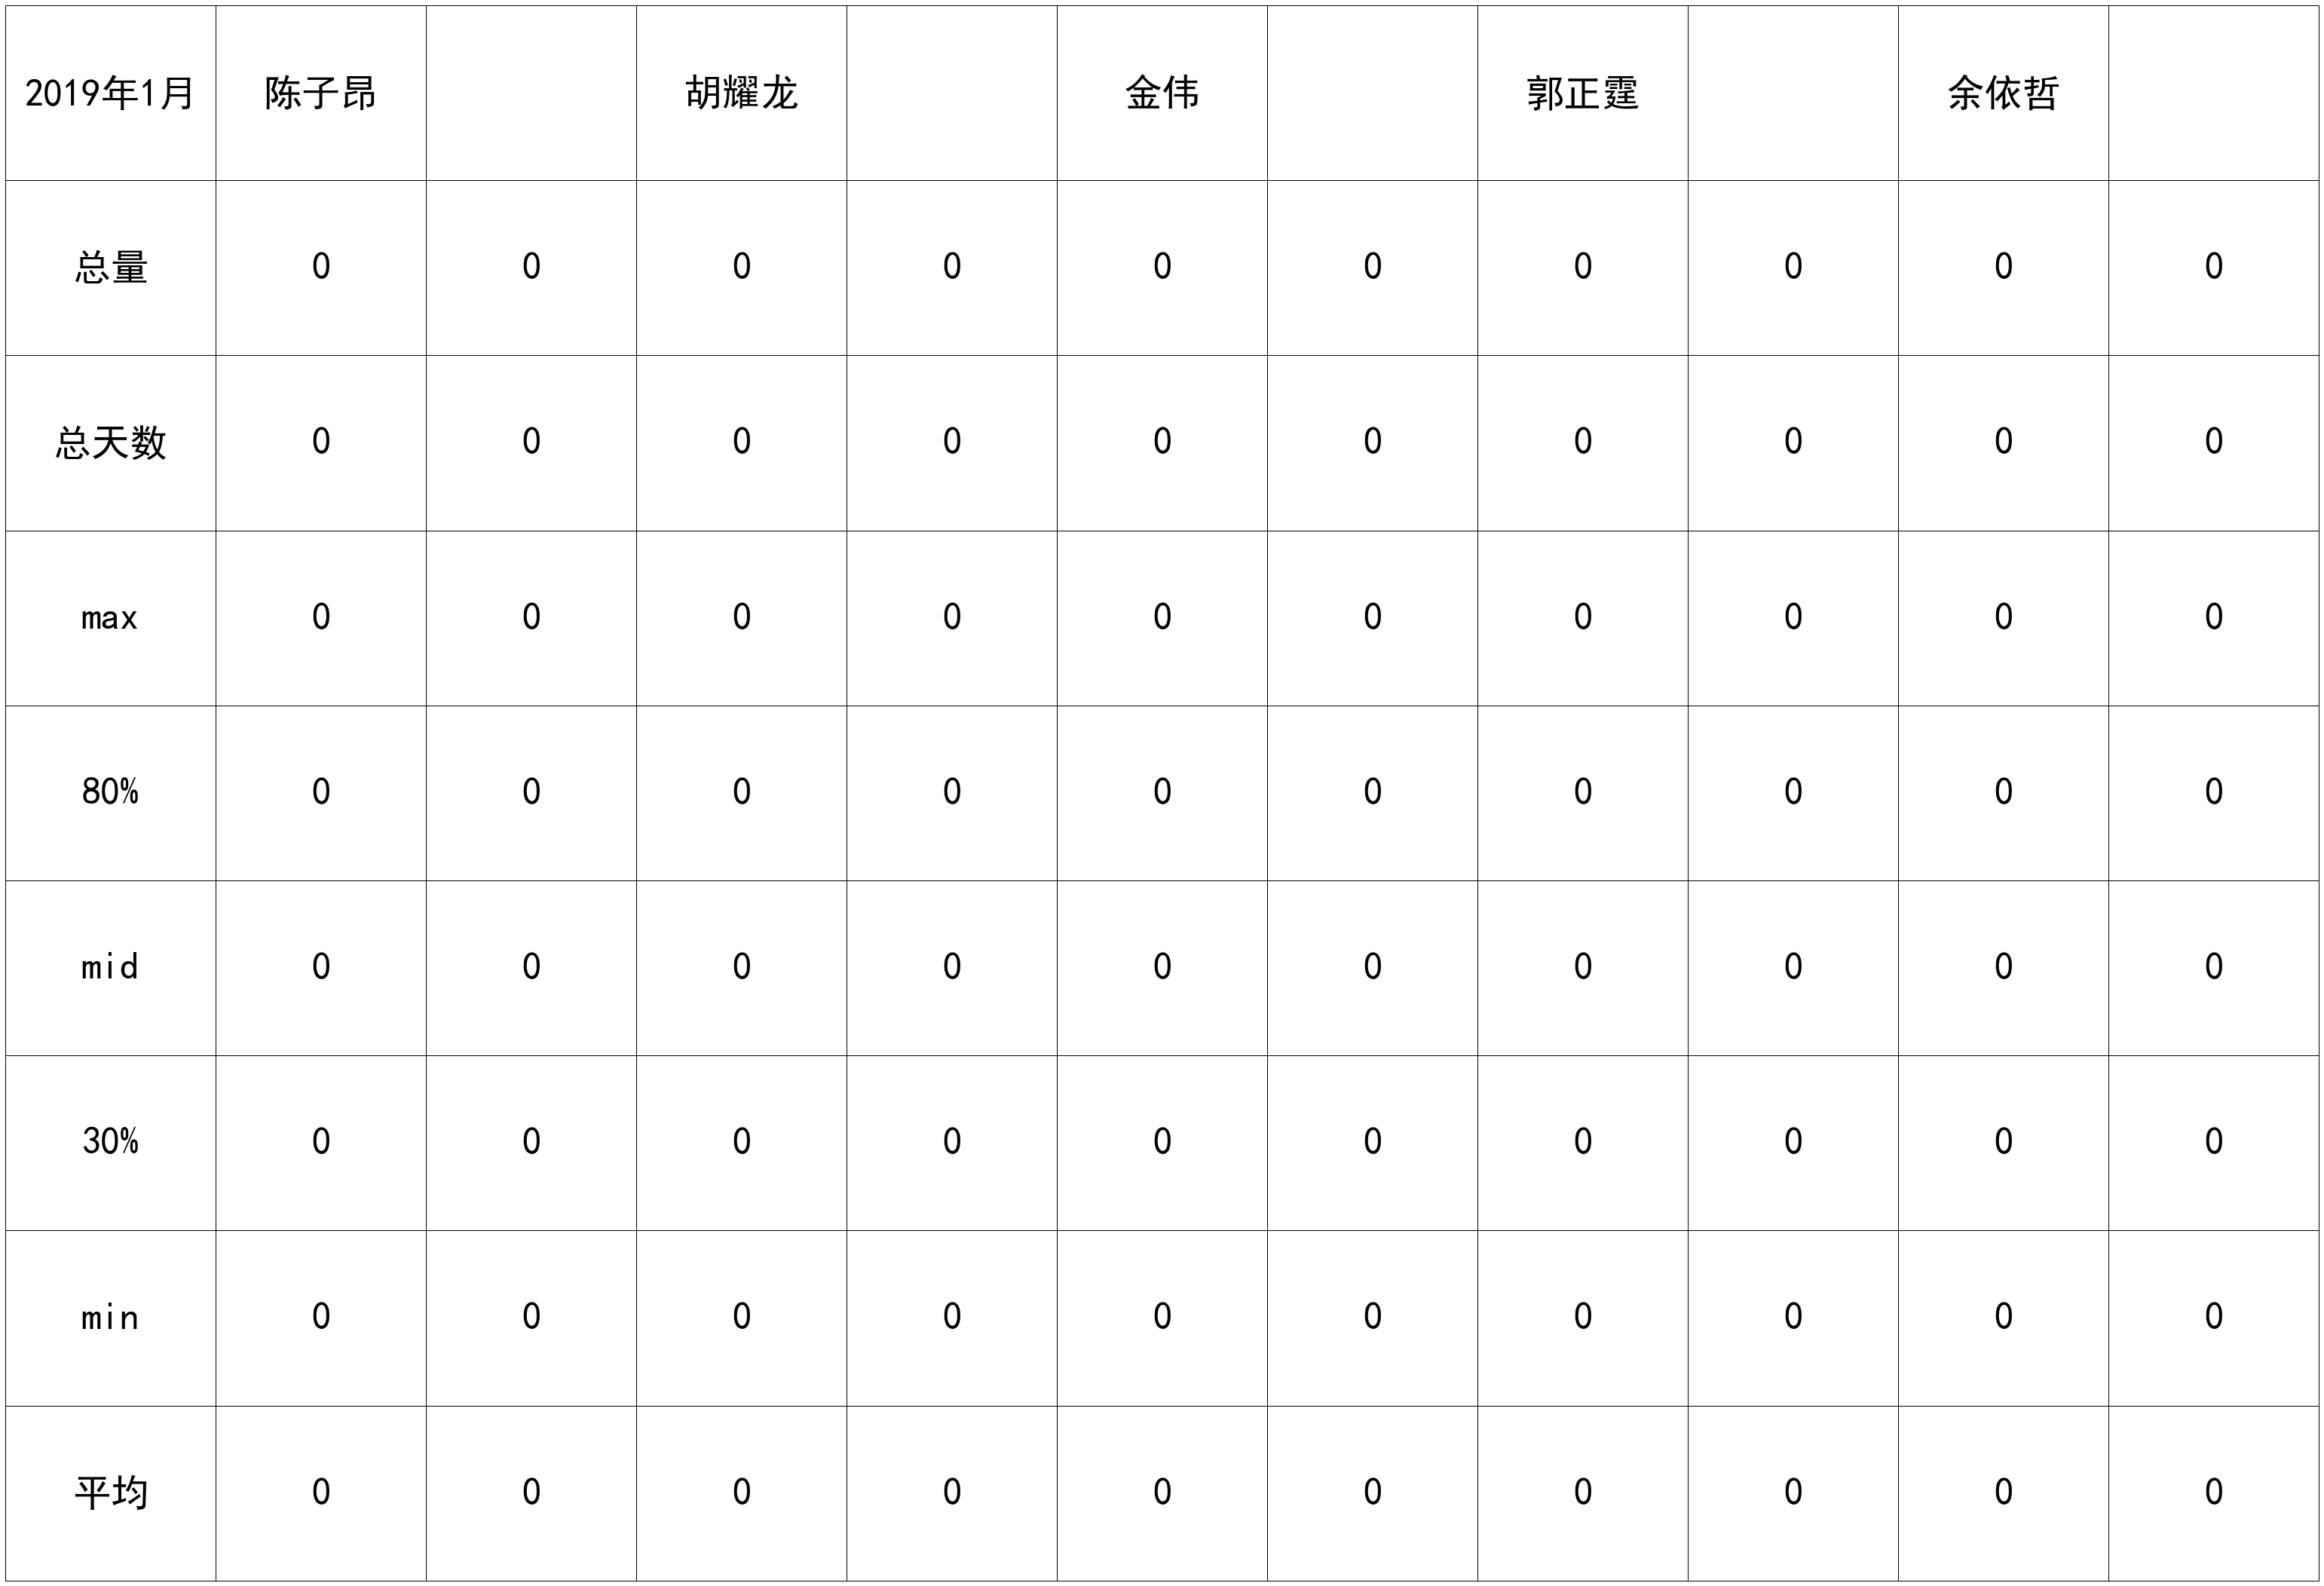

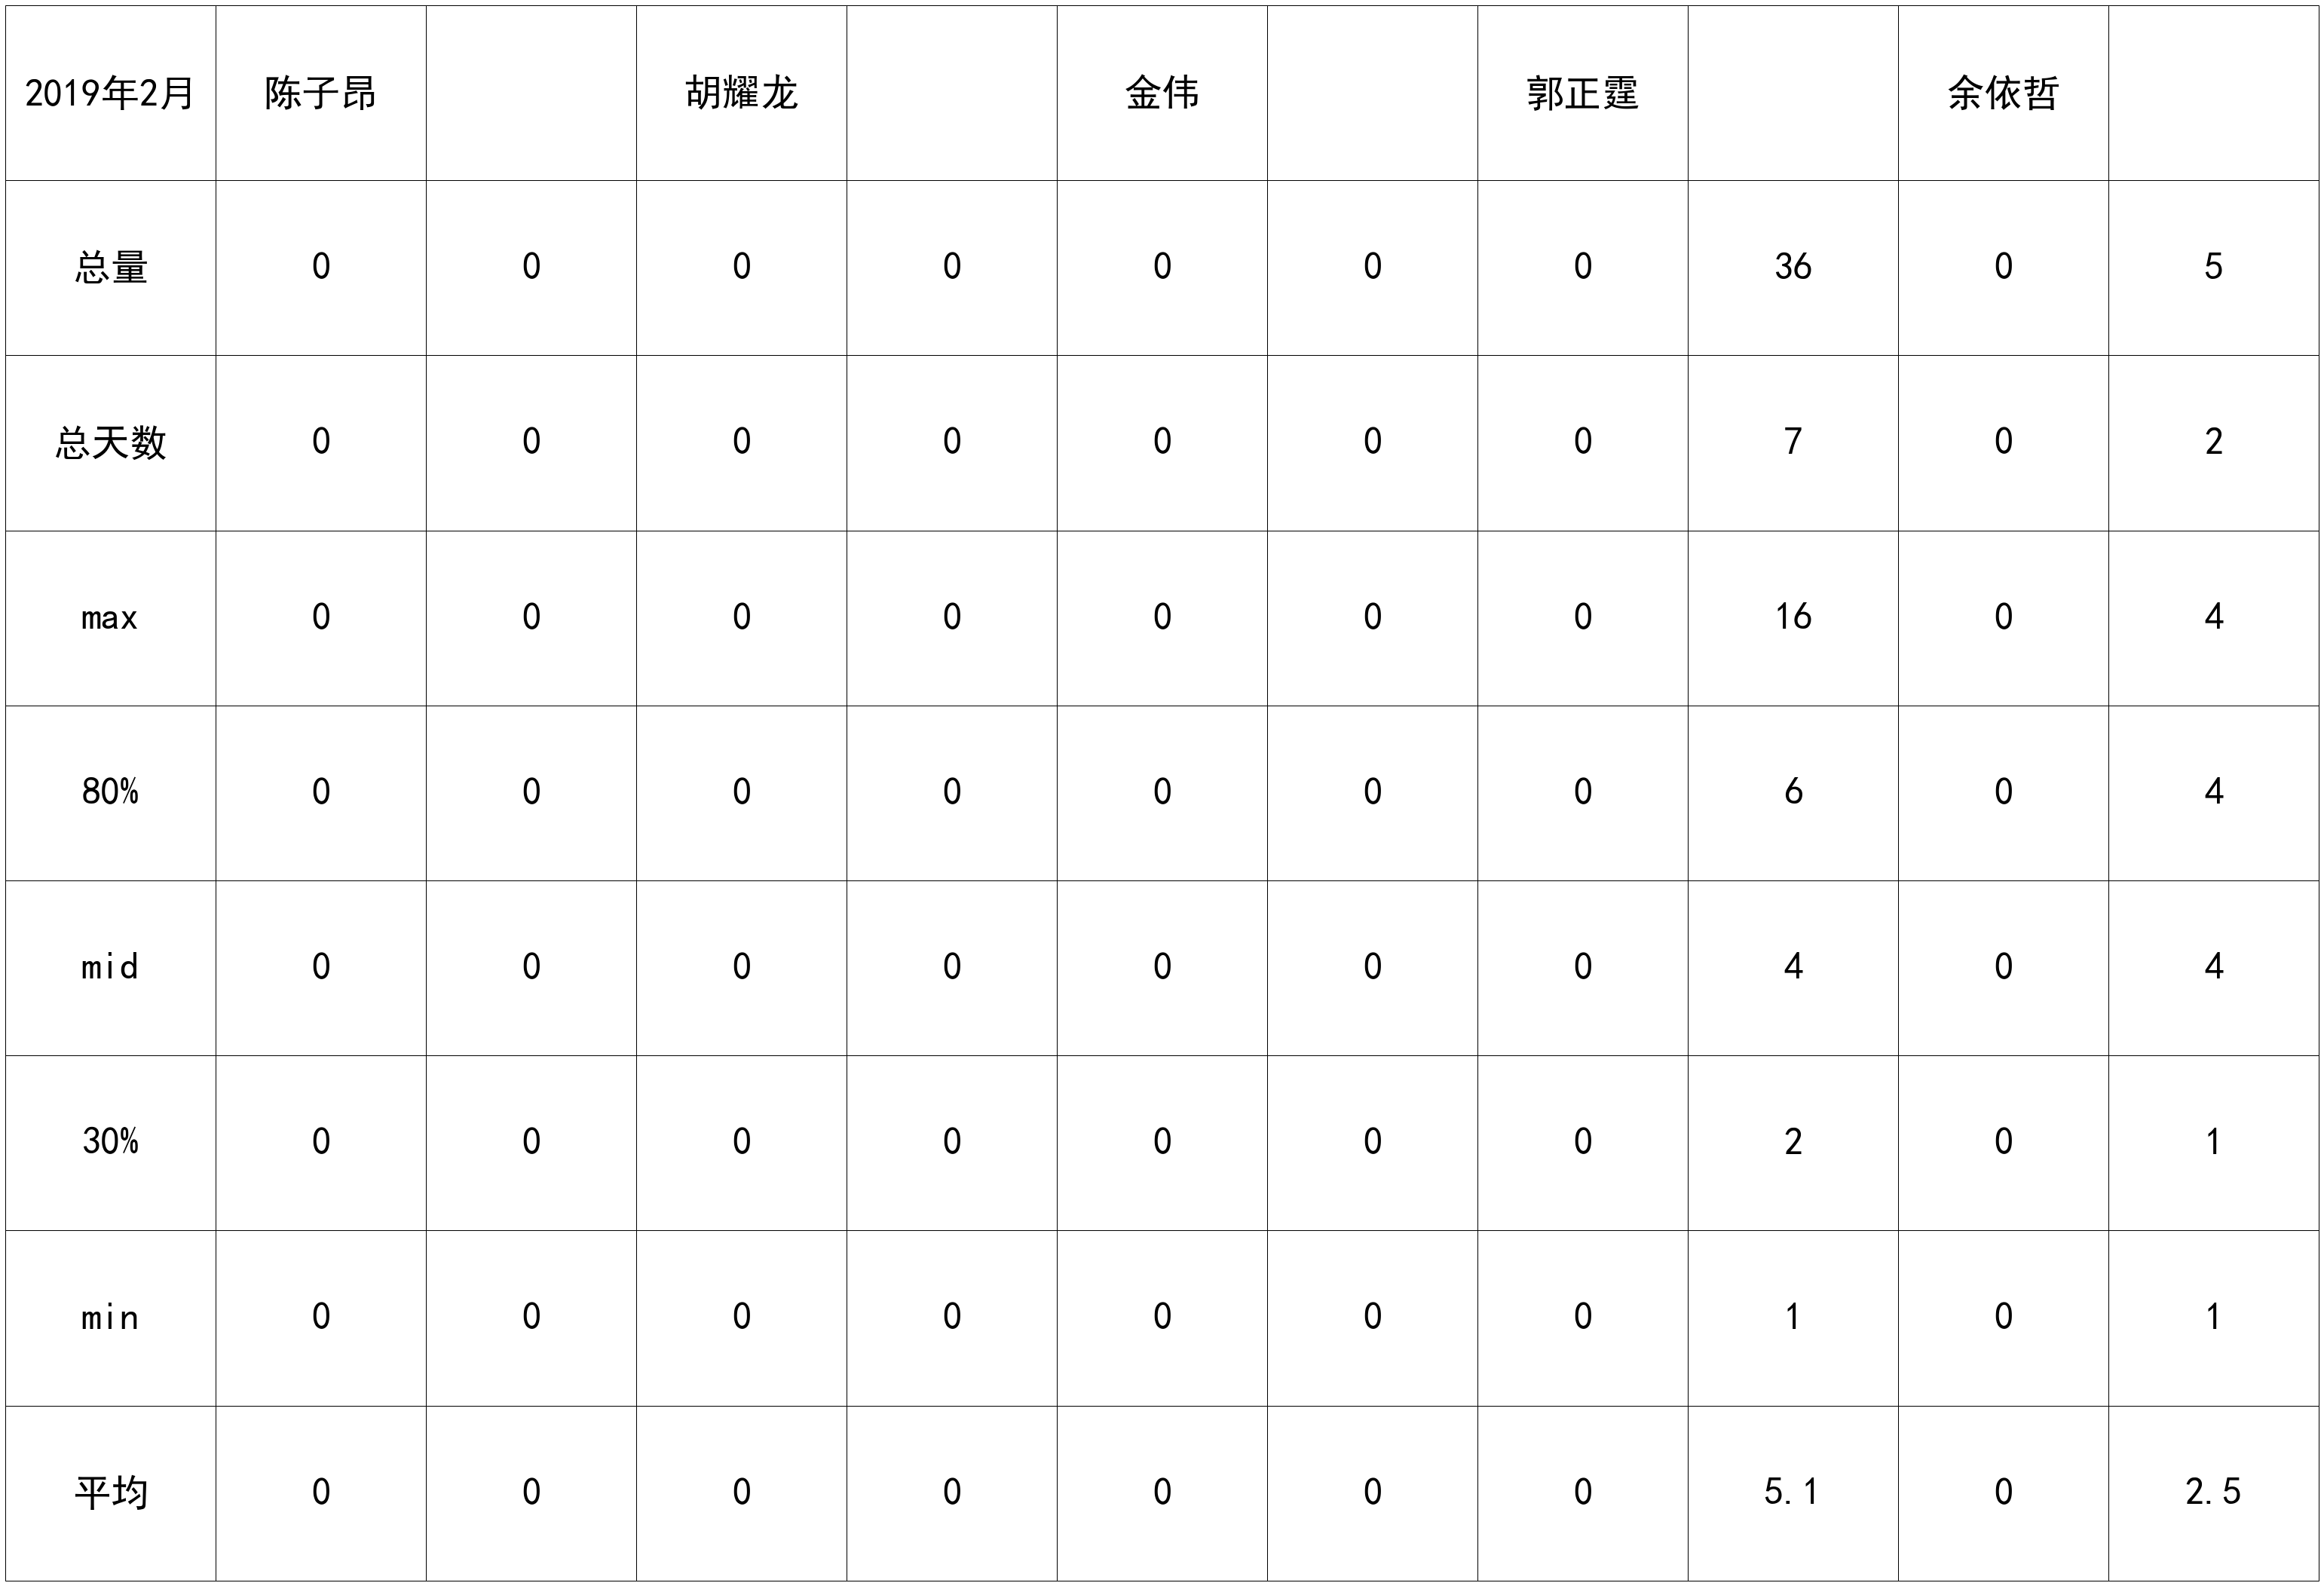

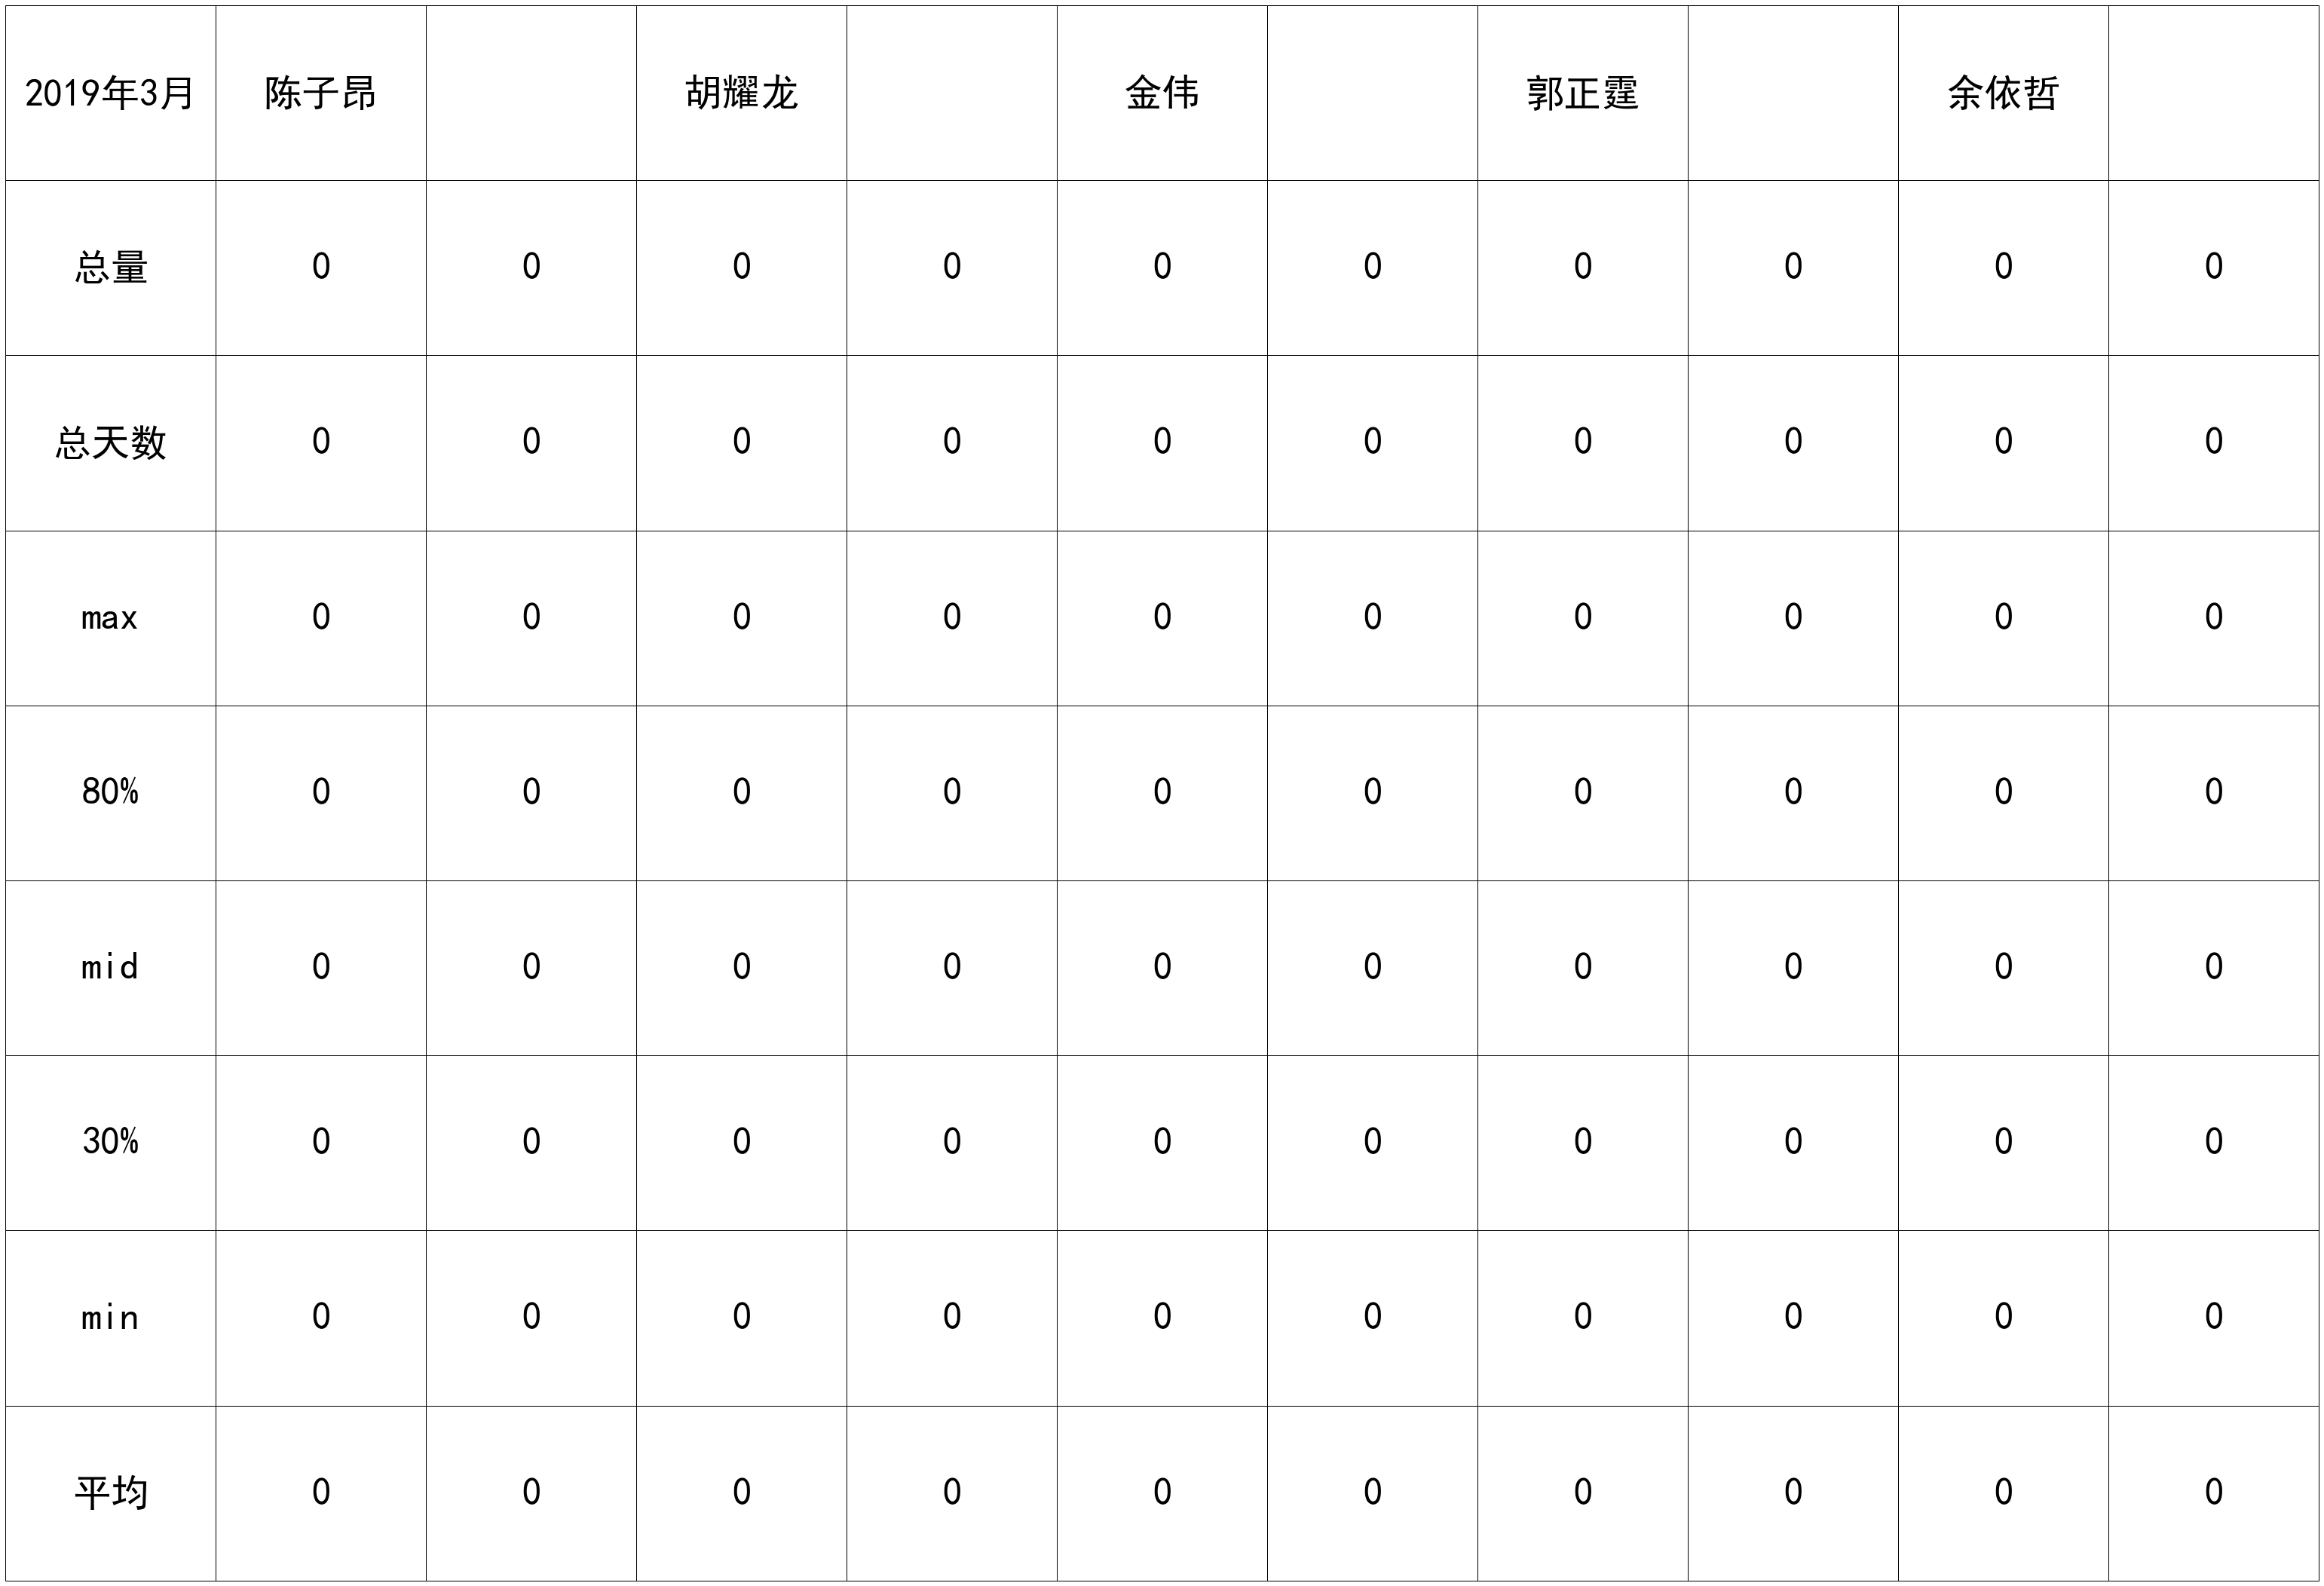

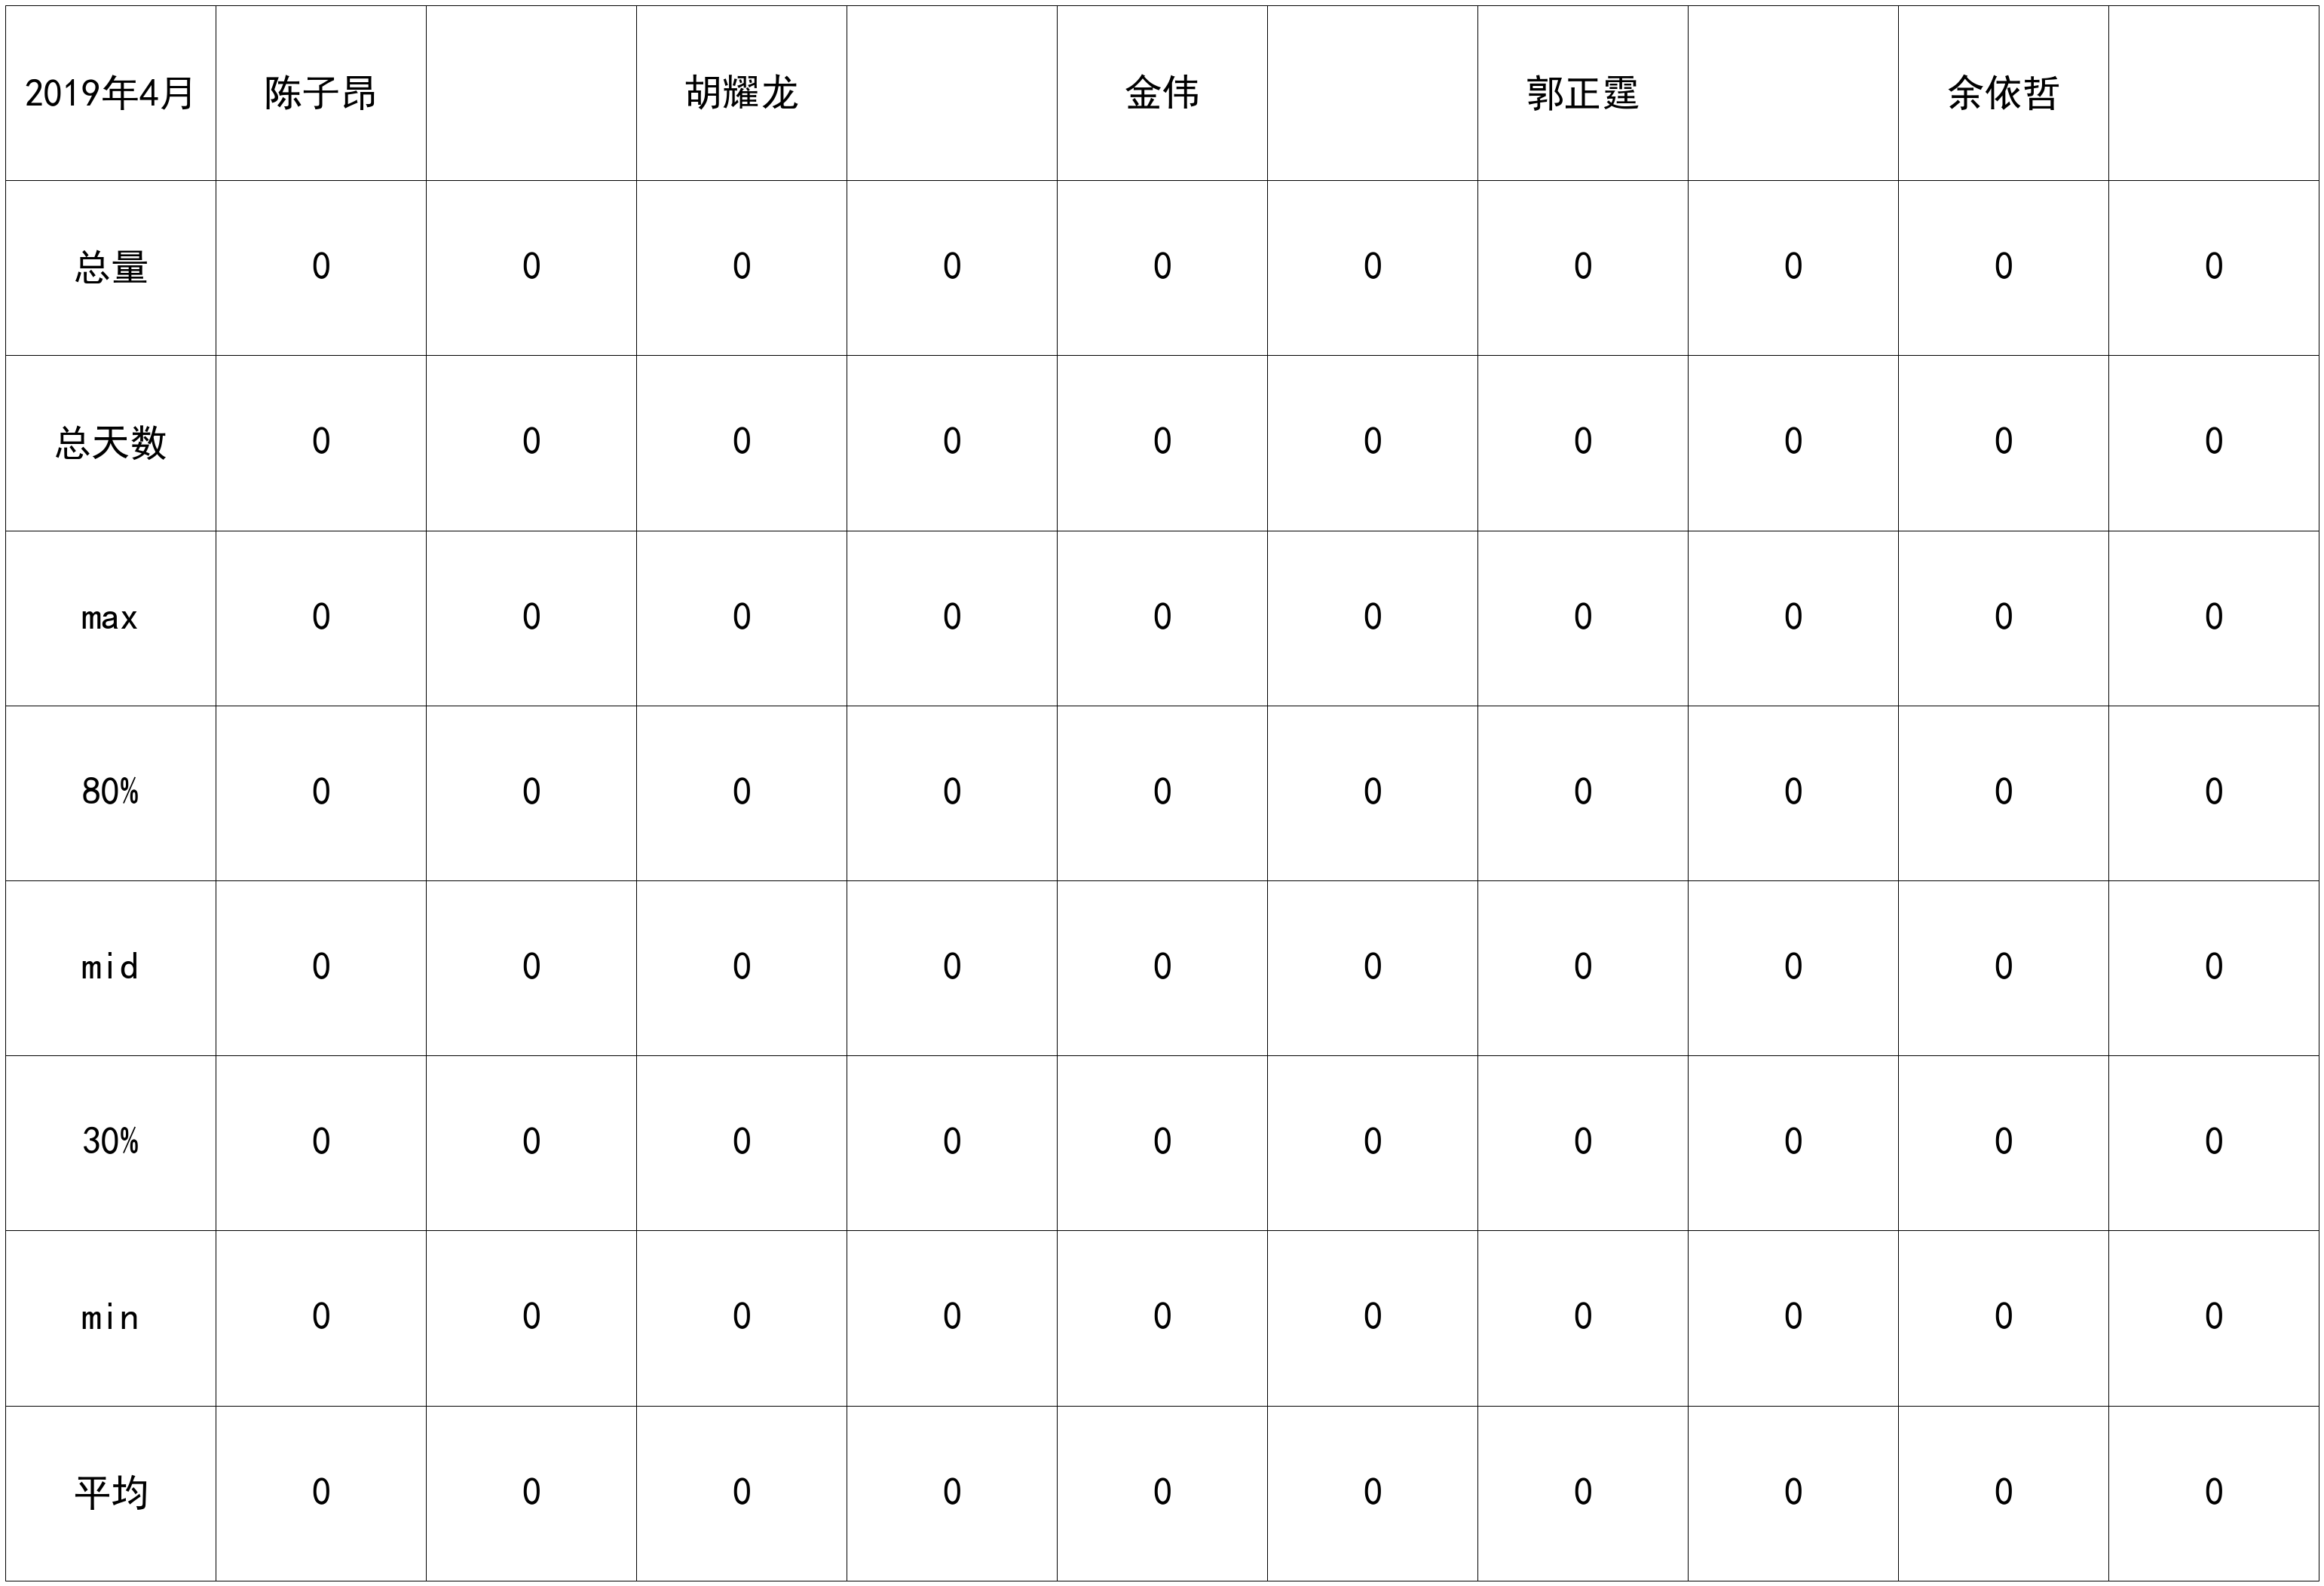

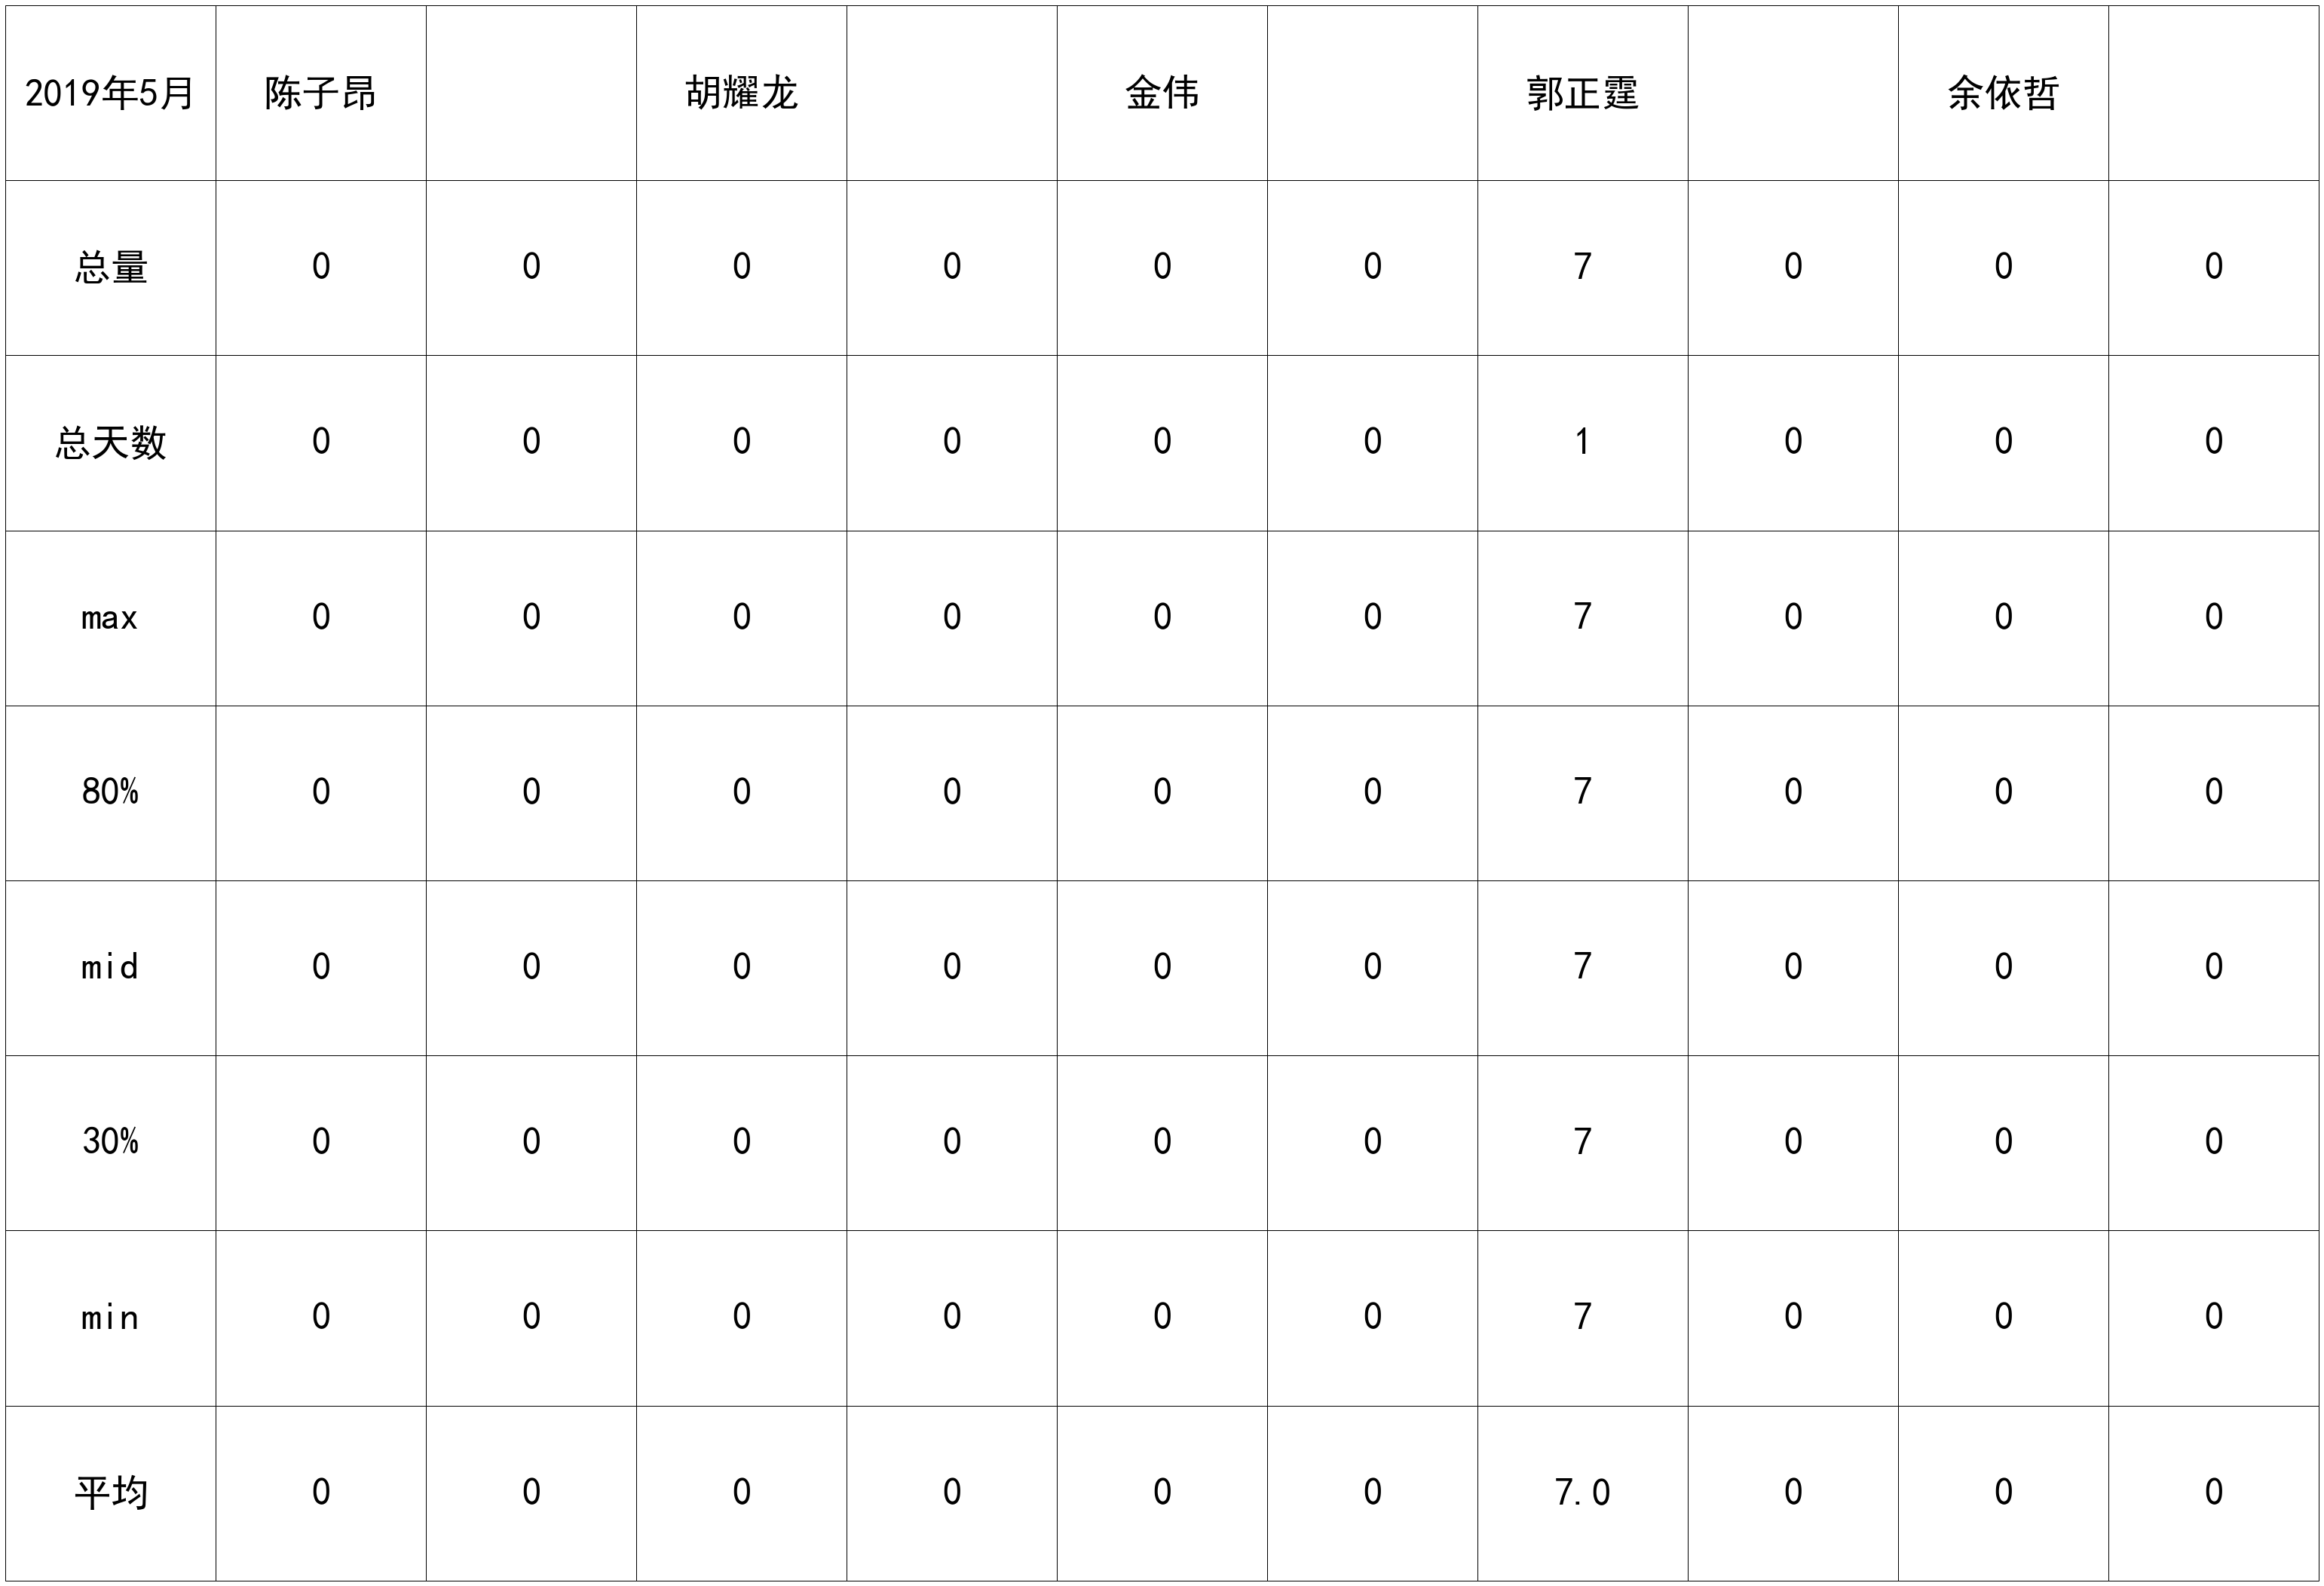

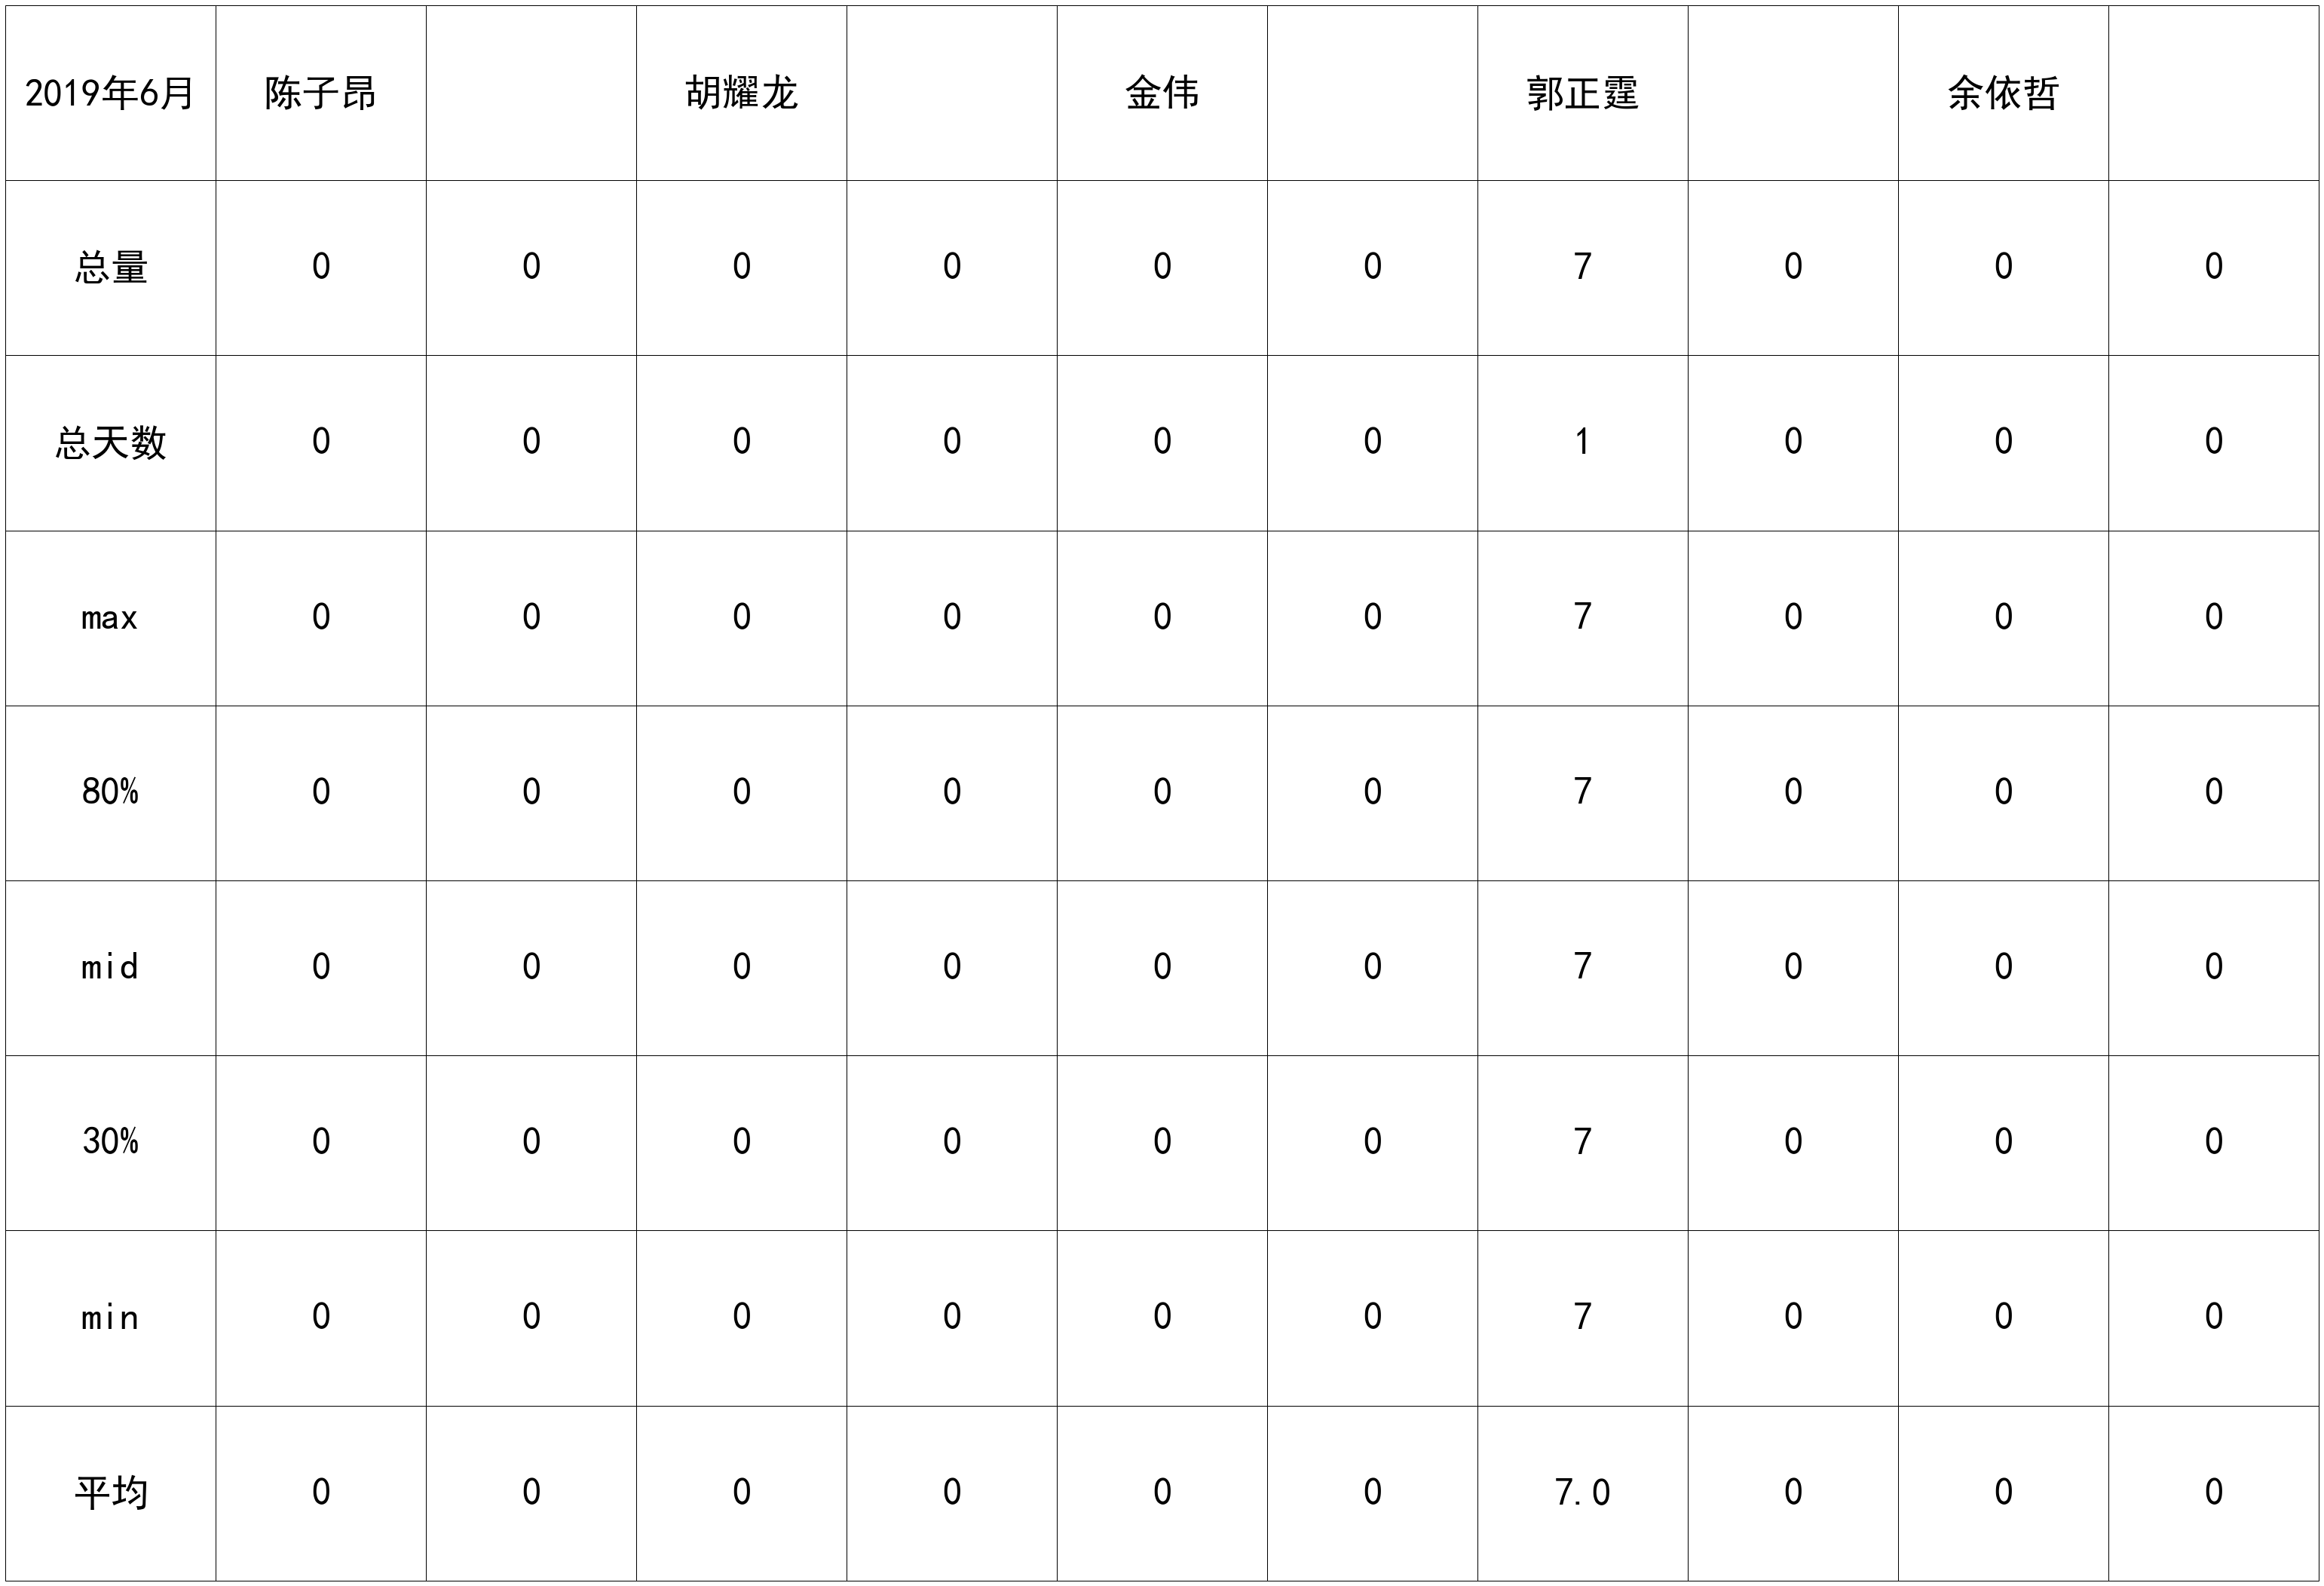

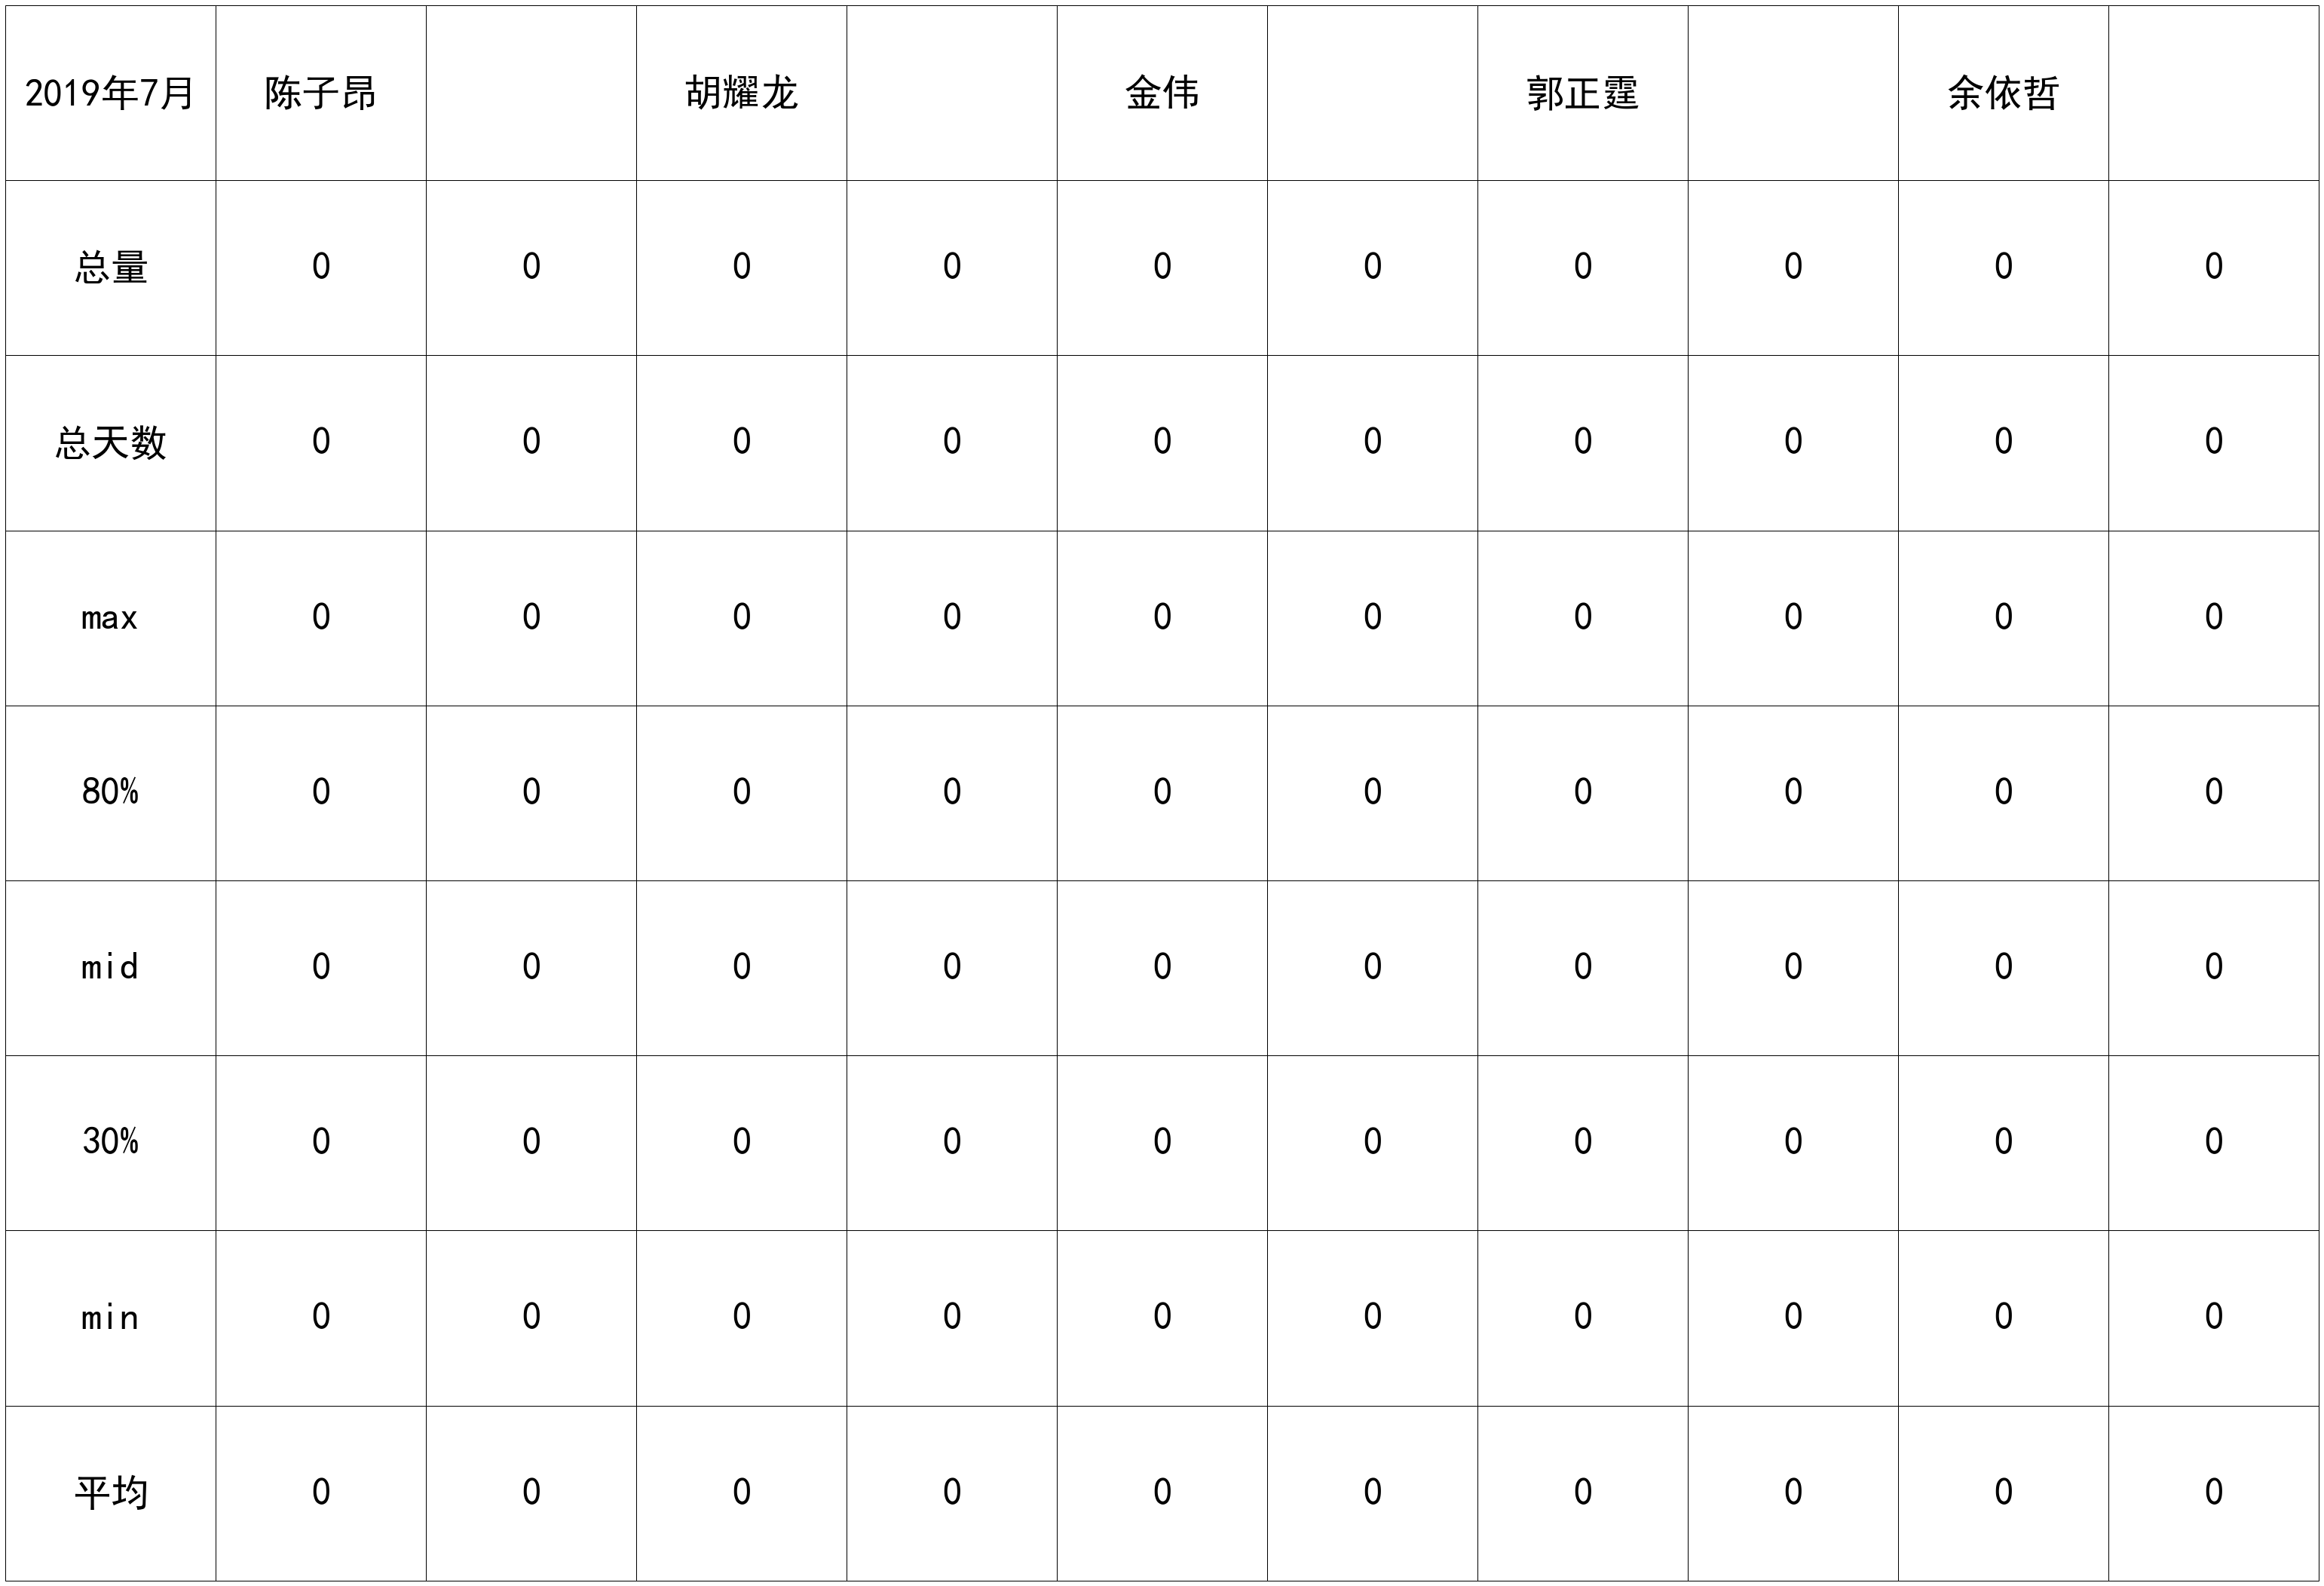

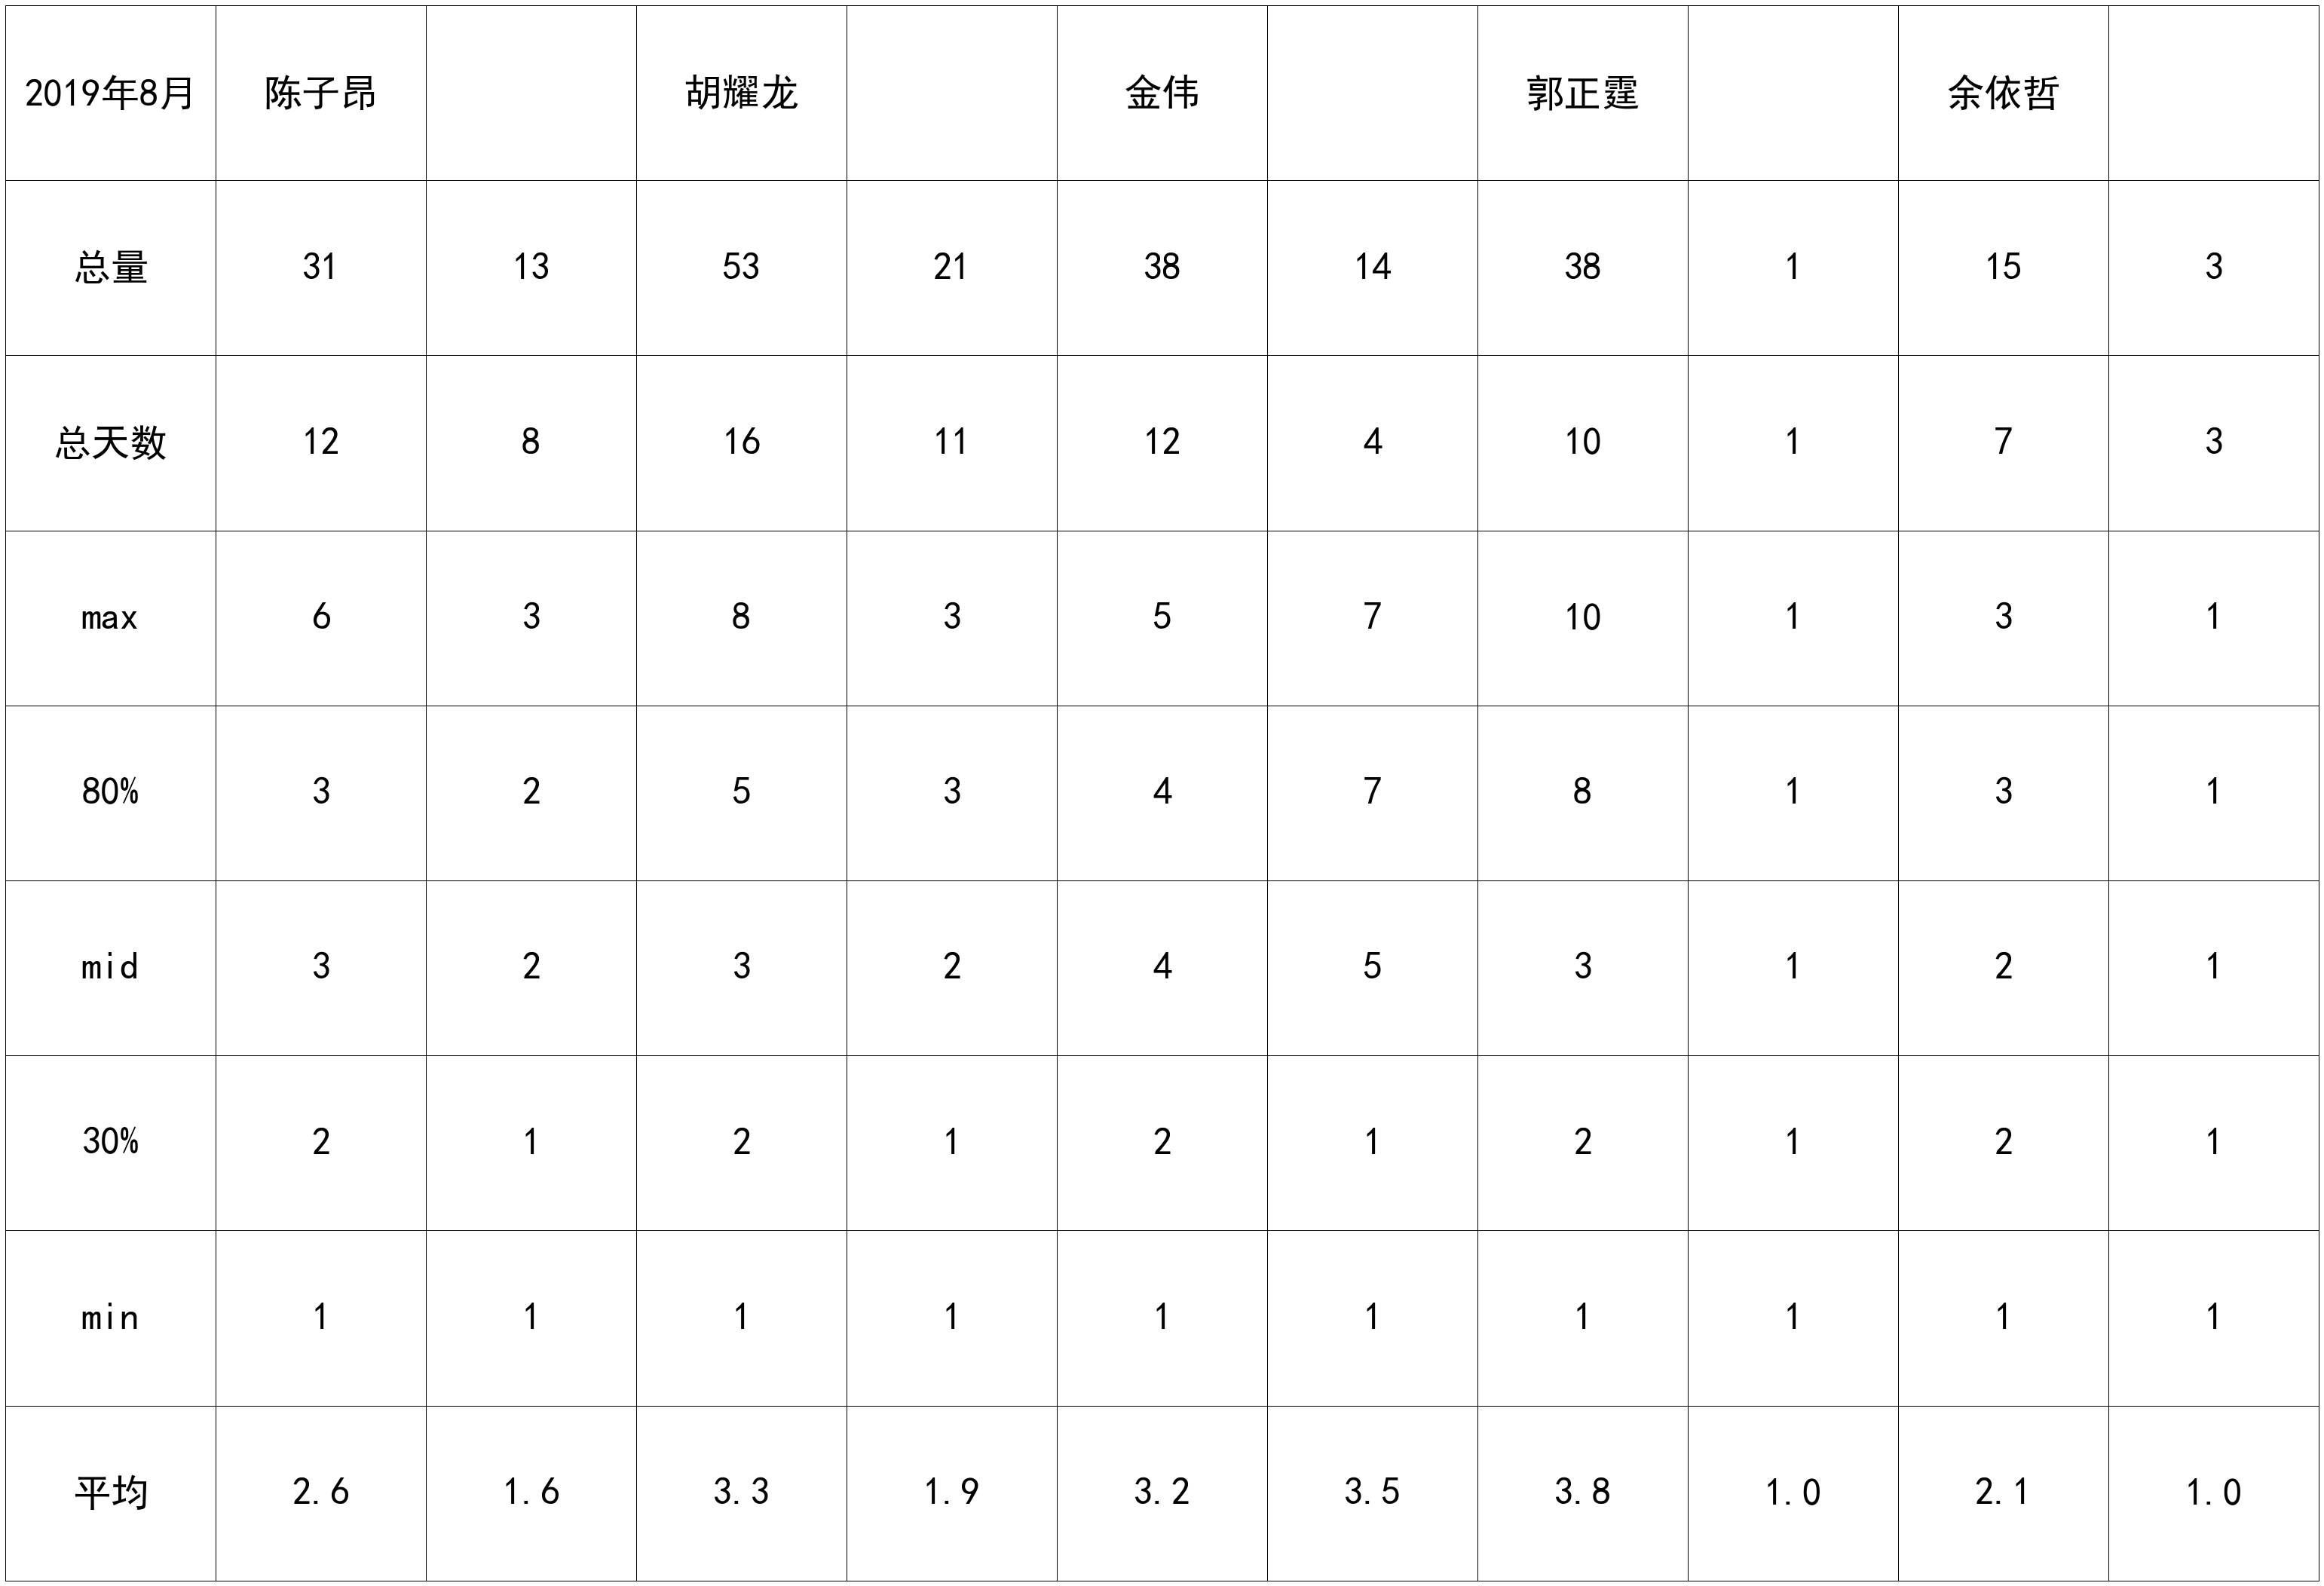

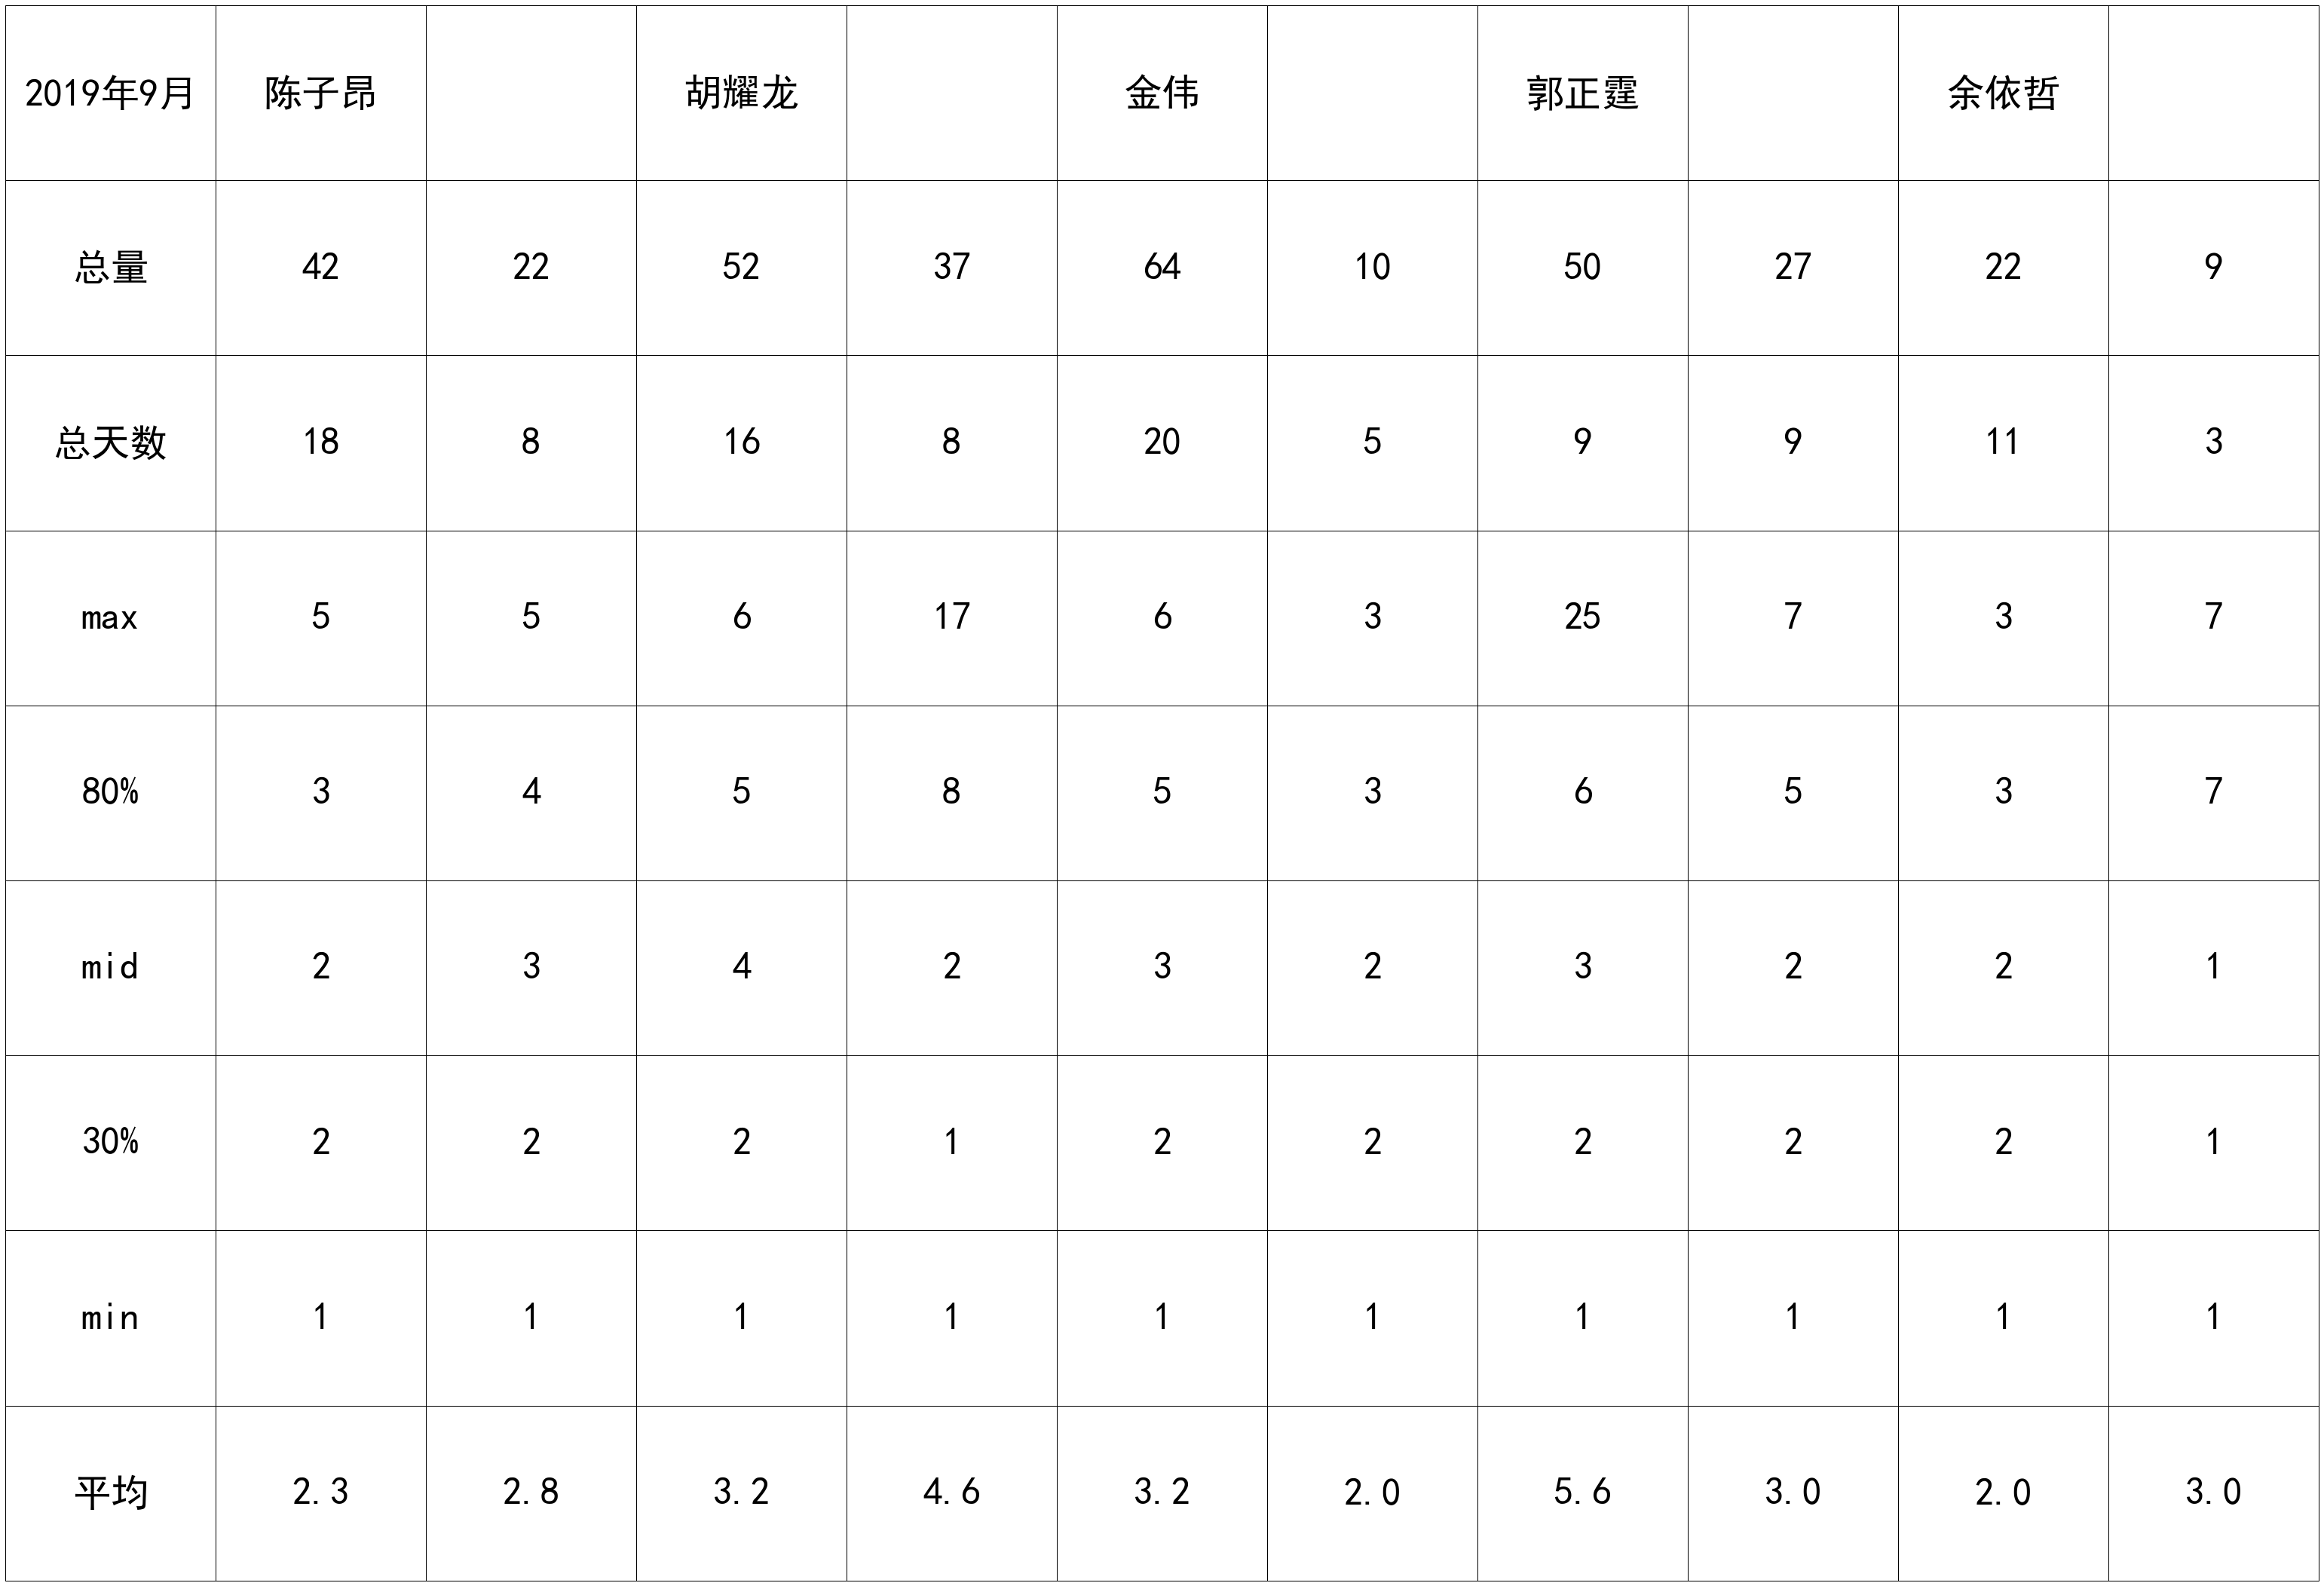

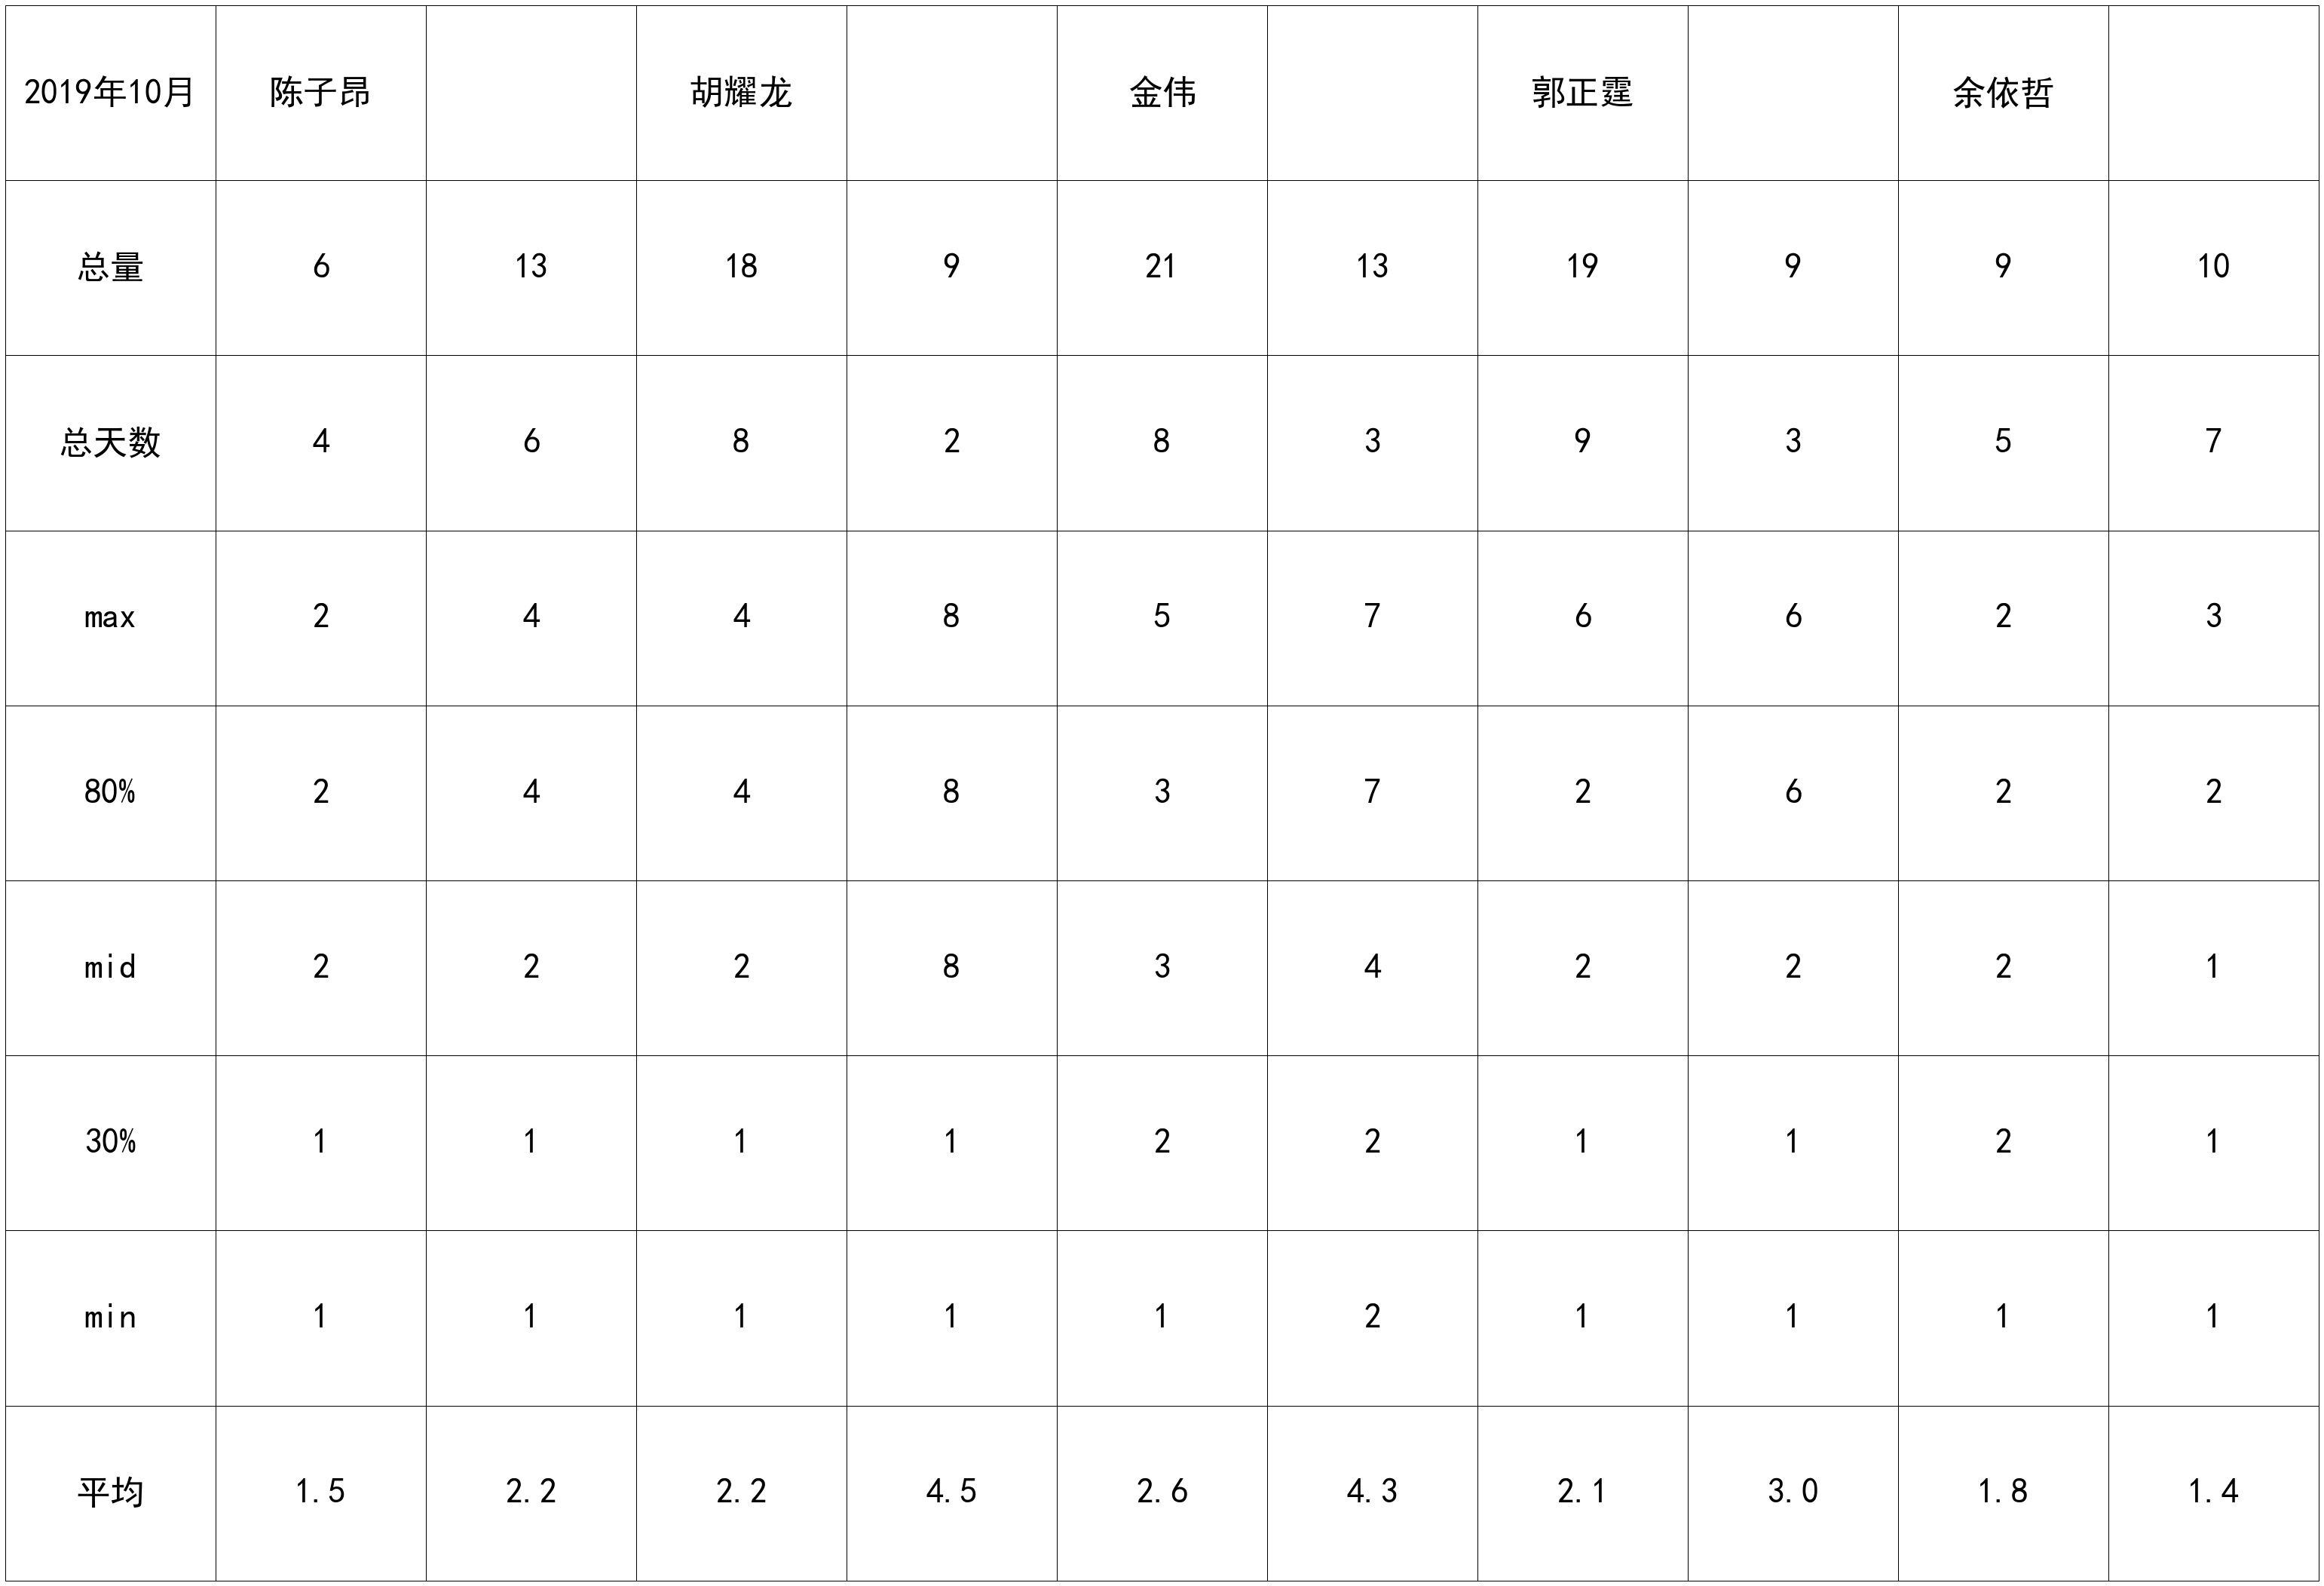

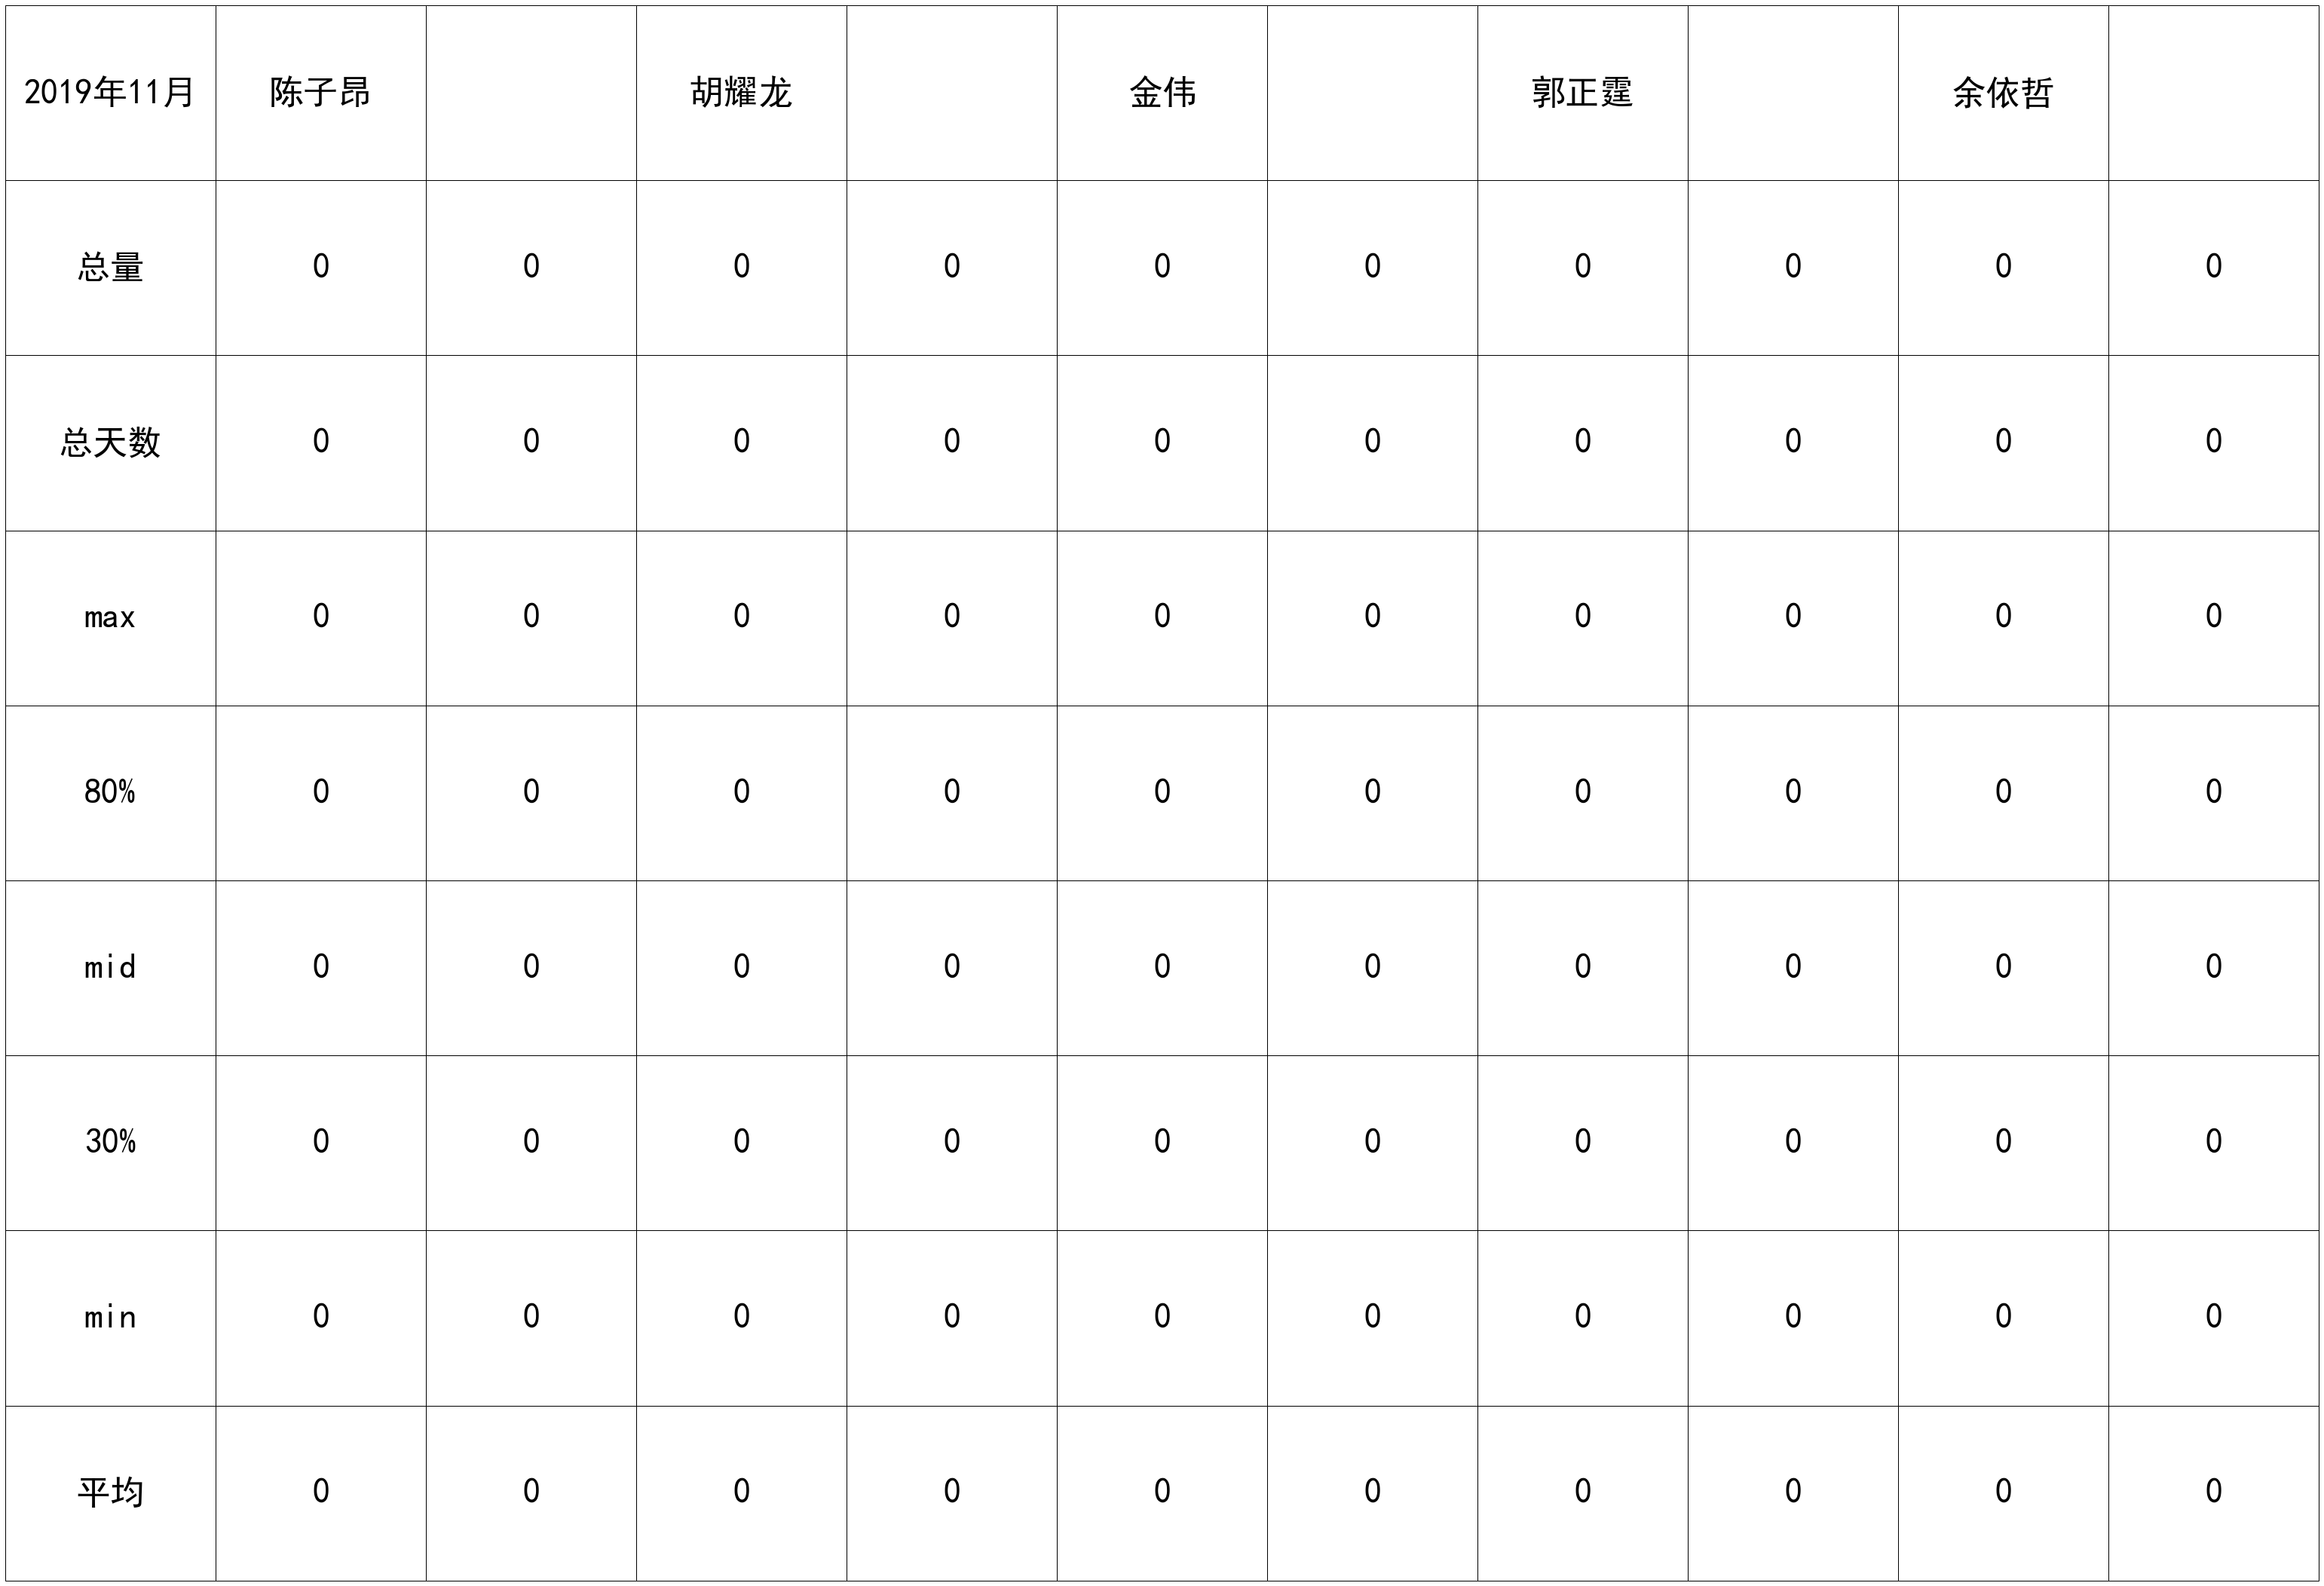

In [10]:
users_num = len(developer)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(111)
ind = np.arange(len(date_template.keys()))
width = 0.25
def autolabel(rects, xpos='center', add_percentage=None):
        xpos = xpos.lower()  # normalize the case of the parameter
        ha = {'center': 'center', 'right': 'left', 'left': 'right'}
        offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
        for index, rect in enumerate(rects):
            height = rect.get_height()
            if add_percentage is None:
                text = '{}'.format(height)
            else:
                text = '{}({}%)'.format(height, str(int(rects1_values[add_percentage][index]*100)))
            ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height, text, ha='right', va='bottom', rotation=-45)
rects1 = plt.bar(ind-width/2, bar_done_list, width, color='red', label='开发完成')
rects2 = plt.bar(ind+width/2, bar_modify_list, width, color='skyblue', label='修改完成')
autolabel(rects1, "center")
autolabel(rects2, "center")
ax.set_xticks(ind)
ax.set_xticklabels(list(date_template.keys()))
plt.show()

def draw_table(tasks_tables, tasks_tables_labels):
    text_value = np.array(tasks_tables)
    fig = plt.figure(figsize=(9,4))
    fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
    the_table=plt.table(cellText=text_value,colLabels=tasks_tables_labels,colWidths=[0.2]*text_value.shape[1],loc='center',cellLoc='center')
    the_table.set_fontsize(60)
    the_table.scale(2.5,2.58)
    fig.set_size_inches(10, 30)
    plt.show()
for i in range(len(all_labels)):
    tasks_tables = all_user_infos[i]
    tasks_tables_labels = all_labels[i]
    draw_table(tasks_tables, tasks_tables_labels)

In [11]:
keys = list(date_template.keys())
values = list(date_template.values())
users_num = len(developer)
# fig = plt.figure(1, figsize=(16, 30))
# def autolabel(rects, xpos='center', add_percentage=None):
#         xpos = xpos.lower()  # normalize the case of the parameter
#         ha = {'center': 'center', 'right': 'left', 'left': 'right'}
#         offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
#         for index, rect in enumerate(rects):
#             height = rect.get_height()
#             if add_percentage is None:
#                 text = '{}'.format(height)
#             else:
#                 text = '{}({}%)'.format(height, str(int(rects1_values[add_percentage][index]*100)))
#             ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height, text, ha='right', va='bottom', rotation=-45)
# def func(pct, allvals):
#     absolute = int(pct/100.*np.sum(allvals))
#     return "{:.1f}%\n({:d})".format(pct, absolute)
# def draw(xyz=(0, 0, 0), key=None, value=None):
#     a = fig.add_subplot(*xyz)
#     index = (xyz[2] - 1) % users_num
#     if index == 0:
#         a.set_ylabel(key)
#     autotexts = plt.pie(value[index], autopct=lambda pct: func(pct, value[index]), shadow=False,
#                         colors=['IndianRed', 'SkyBlue'], startangle=90)[2]
#     plt.setp(autotexts, size='large')
# count = 1
# for i in range(0, len(keys)):
#     key = keys[i]
#     value = values[i]
#     for j in range(0, users_num):
#         draw(xyz=(users_num + 2, users_num, count), key=key, value=value)
#         count += 1
# fig.legend(states, loc="upper right")
# ax = fig.add_subplot(*(users_num + 2, 1, users_num + 2))
# ind = np.arange(users_num)
# width = 0.25
# rects1 = plt.bar(ind-width/2, [i[0] for i in user_info_count], width, color='red', label='开发完成')
# rects2 = plt.bar(ind+width/2, [i[1] for i in user_info_count], width, color='skyblue', label='修改完成')
# autolabel(rects1, "center")
# autolabel(rects2, "center")
# ax.set_xticks(ind)
# ax.set_xticklabels(developer)
# plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

In [13]:
def radar_factory(num_vars, frame='circle'):
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    def draw_poly_patch(self):
        verts = unit_poly_verts(theta + np.pi / 2)
        return plt.Polygon(verts, closed=True, edgecolor='k')
    def draw_circle_patch(self):
        return plt.Circle((0.5, 0.5), 0.5)
    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)
    class RadarAxes(PolarAxes):
        name = 'radar'
        RESOLUTION = 1
        draw_patch = patch_dict[frame]
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')
        def fill(self, *args, closed=True, **kwargs):
            return super().fill(closed=closed, *args, **kwargs)
        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)
        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)
        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)
        def _gen_axes_patch(self):
            return self.draw_patch()
        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            spine_type = 'circle'
            verts = unit_poly_verts(theta + np.pi / 2)
            verts.append(verts[0])
            path = Path(verts)
            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}
    register_projection(RadarAxes)
    return theta
def unit_poly_verts(theta):
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

In [14]:
base = [i for i in range(24)]
example_data = [base]
for name in developer:
    base1 = [0 for _ in range(24)]
    base2 = [0 for _ in range(24)]
    done = Counter(user_info_base[name]['done_habit'])
    for key, value in done.items():
        base1[base.index(key)] = value
    example_data.append((f'{name}开发时间', [base1]))
    modify = Counter(user_info_base[name]['modify_habit'])
    for key, value in modify.items():
        base2[base.index(key)] = value
    example_data.append((f'{name}修改时间', [base2]))

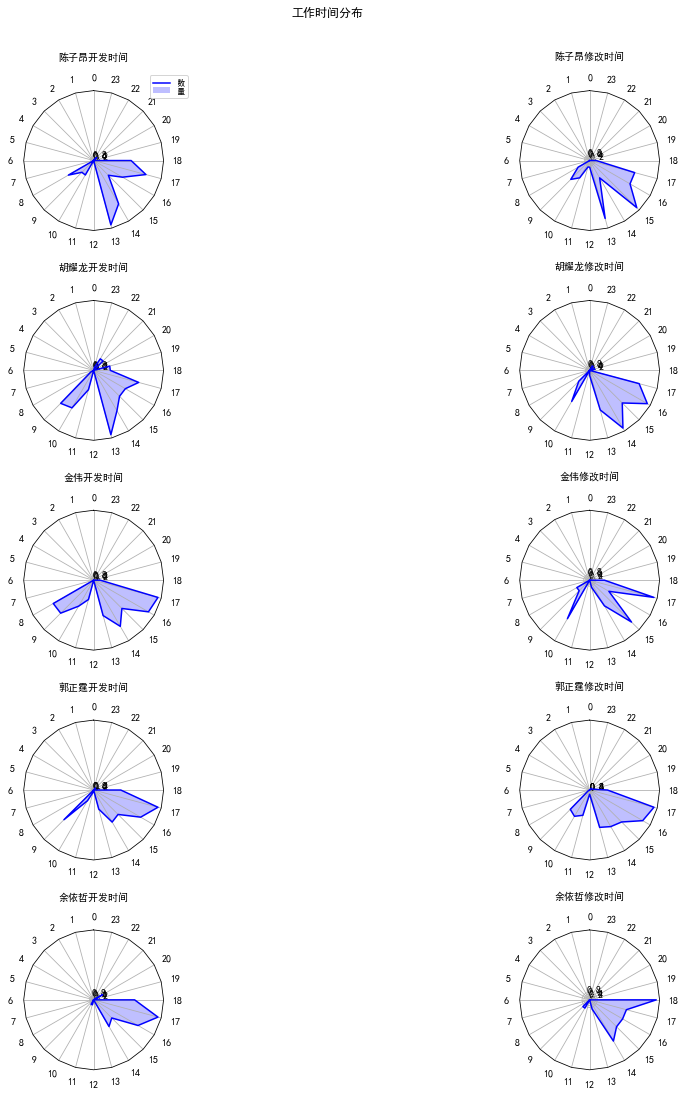

In [15]:
N = 24
theta = radar_factory(N, frame='polygon')

data = example_data
spoke_labels = data.pop(0)

fig, axes = plt.subplots(figsize=(16, 16), nrows=5, ncols=2,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.50, top=0.9, bottom=0.05)

colors = ['b']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.2),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)
ax = axes[0, 0]
labels = ('数量')
legend = ax.legend(labels, loc=(0.9, .95),
                   labelspacing=0.1, fontsize='small')
fig.text(0.5, 0.965, '工作时间分布',
         horizontalalignment='center', color='black', weight='bold',
         size='large')
plt.show()